# IGTDTransformer

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt


class IGTDTransformer(BaseEstimator, TransformerMixin):
    """
    IGTDTransformer: Implements the IGTD (Image Generator for Tabular Data) algorithm
    for transforming tabular data into images for Convolutional Neural Networks:

    1) Optionally select features (variance, std, mad) if desired.
    2) Scale each selected feature to [0,1].
    3) Compute fully rank-based pairwise distances for features and for pixels:
       - The feature distance matrix is turned into ranks (smaller distance => smaller rank).
       - The pixel distance matrix is turned into ranks similarly.
    4) Iterative swapping approach to minimize mismatch between feature-rank matrix (R) and
       pixel-rank matrix (Q):
       - Maintain a vector h of last-swap iterations for each feature.
       - Pick among the oldest features (randomly among ties).
       - Evaluate all swap partners for the biggest improvement.
       - If improvement ratio > t_swap, do the swap.
       - Stop if either:
         a) we exceed max_iterations,
         b) improvement is below a tolerance,
         c) or the improvement over val_step steps is below min_gain.
    5) Transform each sample into an image (black=high value) based on the final assignment.

    Parameters
    ----------
    image_size : tuple of int, default=(5, 5)
        Size of the 2D image (rows, columns).

    feature_selection : str or None, default=None
        Optional method for feature selection. One of {'variance','std','mad'}.

    feature_selection_threshold : float or int or None, default=None
        Threshold or top-k selection for feature selection.

    feature_distance : str, default='pearson'
        Method to calculate feature (dis)similarity.
        Options: {'pearson','spearman','euclidean','jaccard'}.

    pixel_distance : str, default='euclidean'
        Method to calculate pixel coordinate distances.
        Options: {'euclidean','manhattan'}.

    error_measure : str, default='absolute'
        Error measure for mismatch. {'absolute','squared'}.

    max_iterations : int, default=1000
        Maximum iterations for the swapping procedure.

    tolerance : float, default=1e-4
        Convergence tolerance on the per-iteration improvement (delta_error).

    t_swap : float, default=0.0
        Threshold for improvement ratio. If ratio > t_swap, we accept the swap.

    random_state : int or None, default=None
        Random seed for reproducibility.

    verbose : bool, default=False
        Whether to print debugging and progress information.

    The following attributes are set during fit:
    -------------------------------------------
    fitted_ : bool
        Indicator that the transformer is fitted.

    feature_names_ : list of str
        Names of the original columns in the data.

    selected_features_ : list of str
        Features retained after optional selection.

    D_f_ : 2D numpy array of rank-based feature distances (size m x m).

    D_p_ : 2D numpy array of rank-based pixel distances (size m x m).

    feature_mapping_ : dict
        Maps each feature index -> (row,col) pixel in the final arrangement.

    scaler_ : MinMaxScaler
        Used for scaling data to [0,1] range.

    """

    def __init__(self,
                 image_size=(5, 5),
                 feature_selection=None,
                 feature_selection_threshold=None,
                 feature_distance='pearson',
                 pixel_distance='euclidean',
                 error_measure='absolute',
                 max_iterations=1000,
                 tolerance=1e-4,
                 t_swap=0.0,
                 random_state=None,
                 verbose=False,
                 val_step=300,
                 min_gain=1e-5):
        self.image_size = image_size
        self.feature_selection = feature_selection
        self.feature_selection_threshold = feature_selection_threshold
        self.feature_distance = feature_distance
        self.pixel_distance = pixel_distance
        self.error_measure = error_measure
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.t_swap = t_swap
        self.random_state = random_state
        self.verbose = verbose
        self.val_step = val_step
        self.min_gain = min_gain

        self.fitted_ = False
        self.feature_names_ = []
        self.selected_features_ = []
        self.feature_to_index_map_ = {}
        self.index_to_feature_map_ = {}

    def fit(self, X, y=None):
        """Fit the IGTDTransformer on the data: select features, rank-distances, and do iterative swaps."""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self._debug_columns("fit - initial", X)

        # Store original column names
        self.feature_names_ = list(X.columns)

        # Optional: feature selection
        if self.feature_selection is not None:
            X_selected = self._select_features(X)
            self.selected_features_ = list(X_selected.columns)
        else:
            X_selected = X.copy()
            self.selected_features_ = list(X.columns)

        if self.verbose:
            # Limit to first 10 features
            features_to_print = self.selected_features_[:10]
            if len(self.selected_features_) > 10:
                features_to_print += [("...","...")]
            print(f"[fit] final selected_features_ = {features_to_print}")

        self._build_feature_index_map()

        # Scale data [0,1]
        X_array = X_selected.to_numpy()
        self.scaler_ = MinMaxScaler()
        X_normalized = self.scaler_.fit_transform(X_array)

        # Compute rank-based distance matrices
        self.D_f_ = self._compute_feature_rank_matrix(X_normalized)
        self.D_p_ = self._compute_pixel_rank_matrix()

        # Iterative IGTD swapping
        self.feature_mapping_ = self._optimize_mapping_systematic()

        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        """Transform data into images (black=high value) according to final feature->pixel mapping."""
        if not self.fitted_:
            raise RuntimeError("IGTDTransformer is not fitted yet. Call 'fit' first.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_)

        self._debug_columns("transform - initial", X)

        X_selected = X[self.selected_features_]
        X_array = X_selected.to_numpy()
        X_normalized = self.scaler_.transform(X_array)

        # Generate images (inverted so black=high value)
        images = self._generate_images_inverted(X_normalized)
        return images

    def fit_transform(self, X, y=None, **fit_params):
        """Convenience method to fit and transform in one go."""
        return self.fit(X, y).transform(X)

    def get_params(self, deep=True):
        """Return parameters for external usage (e.g. GridSearch)."""
        return {
            'image_size': self.image_size,
            'feature_selection': self.feature_selection,
            'feature_selection_threshold': self.feature_selection_threshold,
            'feature_distance': self.feature_distance,
            'pixel_distance': self.pixel_distance,
            'error_measure': self.error_measure,
            'max_iterations': self.max_iterations,
            'tolerance': self.tolerance,
            't_swap': self.t_swap,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'val_step': self.val_step,
            'min_gain': self.min_gain
        }

    def set_params(self, **params):
        """Set parameters for this estimator."""
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def _select_features(self, X):
        """Optionally select features based on variance, std, or mad."""
        self._debug_columns("_select_features - input", X)
        method = self.feature_selection
        threshold = self.feature_selection_threshold

        if method == 'variance':
            scores = X.var()
        elif method == 'std':
            scores = X.std()
        elif method == 'mad':
            scores = X.mad()
        else:
            raise ValueError(f"Unsupported feature_selection method: {method}")

        if isinstance(threshold, float):
            selected = scores[scores > threshold].index.tolist()
        elif isinstance(threshold, int):
            selected = scores.sort_values(ascending=False).head(threshold).index.tolist()
        elif threshold is None:
            half = max(1, len(scores)//2)
            selected = scores.sort_values(ascending=False).head(half).index.tolist()
        else:
            raise ValueError("feature_selection_threshold must be float, int, or None.")

        if len(selected) == 0:
            warnings.warn("No features selected. Using all features.")
            selected = list(X.columns)

        if self.verbose:
            print(f"Selected {len(selected)} features using {method} with threshold={threshold}.")
        result = X[selected]
        self._debug_columns("_select_features - output", result)
        return result

    def _build_feature_index_map(self):
        """Create a map: feature name -> index and index -> feature name."""
        self.feature_to_index_map_ = {
            feat: i for i, feat in enumerate(self.selected_features_)
        }
        self.index_to_feature_map_ = {
            i: feat for feat, i in self.feature_to_index_map_.items()
        }
        if self.verbose:
            # Limit to first 10 items
            items_to_print = list(self.feature_to_index_map_.items())[:10]
            if len(self.feature_to_index_map_) > 10:
                items_to_print += [("...","...")]
            print(f"[_build_feature_index_map] => {items_to_print}")

    def _compute_feature_rank_matrix(self, X_normalized):
        """
        Compute rank-based distances among features.
        If feature_distance='pearson', we do 1-abs(corr), then rank.
        If 'spearman', we rank the data first, then 1-abs(corr).
        If 'euclidean' or 'jaccard', we compute pairwise distances, then rank them.
        Return a rank matrix of shape (m, m).
        """
        num_features = X_normalized.shape[1]
        # build an m x m distance or correlation matrix
        dist_mat = np.zeros((num_features, num_features))

        method = self.feature_distance.lower()

        if method in ['pearson','spearman']:
            # correlation path
            if method == 'pearson':
                corr = np.corrcoef(X_normalized, rowvar=False)
            else:
                # Spearman => rank data first, then corr
                rank_df = pd.DataFrame(X_normalized).rank()
                corr = np.corrcoef(rank_df, rowvar=False)

            dist_mat = 1.0 - np.abs(corr)
        elif method in ['euclidean','jaccard']:
            # compute pairwise distances
            # jaccard requires binary data
            from scipy.spatial.distance import pdist, squareform
            pair_dist = pdist(X_normalized.T, metric=method)
            dist_mat = squareform(pair_dist)
        else:
            raise ValueError(f"Unsupported feature_distance: {self.feature_distance}")

        # Now convert to ranks
        # Only rank the lower triangle
        # 1) extract lower-tri
        tril_idx = np.tril_indices(num_features, k=-1)
        lower_vals = dist_mat[tril_idx]
        # 2) rank them
        ranks = rankdata(lower_vals, method='ordinal')  # method='ordinal' => distinct ranks
        # 3) create a rank matrix
        rank_mat = np.zeros((num_features, num_features))
        rank_mat[tril_idx] = ranks
        rank_mat = rank_mat + rank_mat.T  # mirror it
        rank_mat /= rank_mat.max()  # normalize to [0,1]
        return rank_mat

    def _compute_pixel_rank_matrix(self):
        """
        Compute rank-based distances among pixel coordinates in a (r,c) grid.
        Return an (m x m) rank matrix.
        """
        r, c = self.image_size
        m = r*c
        if m < len(self.selected_features_):
            raise ValueError(f"Image size {self.image_size} < #features={len(self.selected_features_)}")

        coords = np.array([(i, j) for i in range(r) for j in range(c)])
        method = self.pixel_distance.lower()

        if method not in ['euclidean','manhattan']:
            raise ValueError(f"Unsupported pixel_distance: {self.pixel_distance}")

        pair_dist = pdist(coords, metric=method)
        dist_mat = squareform(pair_dist)

        # rank the lower triangle
        tril_idx = np.tril_indices(m, k=-1)
        lower_vals = dist_mat[tril_idx]
        ranks = rankdata(lower_vals, method='ordinal')
        rank_mat = np.zeros((m, m))
        rank_mat[tril_idx] = ranks
        rank_mat = rank_mat + rank_mat.T
        rank_mat /= rank_mat.max()  # normalize to [0,1]
        return rank_mat

    def _optimize_mapping_systematic(self):
        """
        Perform IGTD iterative swapping:

        - h vector tracks last-swap iteration for each feature.
        - In each iteration, pick the feature(s) with the oldest h value. If there's a tie, pick randomly.
        - Evaluate all swaps, pick best improvement. If ratio>t_swap, do swap.
        - We track errors in err_record. If for val_step steps there's no gain>min_gain, we stop.
        - Also stop if delta_error < tolerance or we exceed max_iterations.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)

        m = self.D_f_.shape[0]
        pixel_indices = list(range(m))  # each pixel index from 0..m-1
        feature_indices = list(range(m))

        # initial assignment: feature i -> pixel i
        assignment = {feat_idx: pixel_indices[feat_idx] for feat_idx in feature_indices}

        # initial error
        current_error = self._compute_total_error(assignment)
        if self.verbose:
            print(f"\nInitial error: {current_error:.4f}")

        # track iteration / last-swap vector
        h = np.full(m, -np.inf)
        err_record = [current_error]
        pre_err = current_error

        # main loop
        step = 0
        while step < self.max_iterations:
            # pick the oldest feature(s)
            oldest = np.where(h == np.min(h))[0]
            # random pick among ties
            n_star = np.random.choice(oldest) if len(oldest)>1 else oldest[0]

            base_error = pre_err
            best_delta = 0.0
            best_l = None

            # search all partners
            for l in range(m):
                if l == n_star:
                    continue
                delta = self._compute_swap_delta(n_star, l, assignment)
                if delta < best_delta:
                    best_delta = delta
                    best_l = l

            improvement = -best_delta
            ratio = improvement / base_error if base_error>0 else 0.0

            if best_l is not None and ratio > self.t_swap:
                # do swap
                old_p_ns = assignment[n_star]
                old_p_l = assignment[best_l]
                assignment[n_star], assignment[best_l] = old_p_l, old_p_ns
                new_err = base_error + best_delta
                pre_err = new_err
                h[n_star] = step
                h[best_l] = step
            else:
                # skip swap
                new_err = base_error
                pre_err = new_err
                h[n_star] = step

            err_record.append(new_err)
            if self.verbose and step%100==0:
                print(f"Step {step}, err: {new_err:.4f}, ratio={ratio:.6f}")

            # check if improvement < tolerance
            if best_l is not None and abs(best_delta) < self.tolerance:
                if self.verbose:
                    print(f"Converged at step {step} with delta_err={best_delta:.6f}")
                break

            # stopping: if s > val_step, check last val_step improvements
            if step > self.val_step:
                recent = err_record[-self.val_step:]
                old_val = err_record[-self.val_step-1]
                gains = (old_val - np.array(recent)) / (old_val+1e-12)
                # if no gain >= min_gain, stop
                if np.sum(gains >= self.min_gain) == 0:
                    if self.verbose:
                        print(f"No sufficient improvement in last {self.val_step} steps. Stopping.")
                    break

            step += 1
            if step >= self.max_iterations:
                if self.verbose:
                    print(f"Reached max_iterations limit at step {step}.")
                break

        # final assignment => build mapping
        feature_mapping = {}
        for feat_idx, px in assignment.items():
            row = px // self.image_size[1]
            col = px % self.image_size[1]
            feature_mapping[feat_idx] = (row, col)

        if self.verbose:
            print(f"Final error: {pre_err:.4f}, steps used: {step}")
        return feature_mapping

    def _compute_swap_delta(self, f1, f2, assignment):
        """
        Partial error recompute for swapping f1 <-> f2 in assignment.
        Negative delta => improvement.
        """
        old_p1 = assignment[f1]
        old_p2 = assignment[f2]

        old_err = 0.0
        new_err = 0.0

        # check pairs (f1,x), (f2,x), plus the pair (f1,f2)
        feats_to_check = [f1, f2]
        for x in range(len(assignment)):
            if x not in feats_to_check:
                # old
                old_err += self._pair_error(f1, x, assignment)
                old_err += self._pair_error(f2, x, assignment)
                # new => swap in local
                new_err += self._pair_error_after_swap(f1, x, old_p2, assignment)
                new_err += self._pair_error_after_swap(f2, x, old_p1, assignment)

        # pair (f1,f2) itself
        old_err += self._pair_error(f1, f2, assignment)
        new_err += self._pair_error_pair_after_swap(f1, f2, old_p1, old_p2, assignment)
        return new_err - old_err

    def _compute_total_error(self, assignment):
        """Compute total mismatch error across all feature pairs."""
        m = self.D_f_.shape[0]
        total = 0.0
        for i in range(m):
            for j in range(i+1, m):
                total += self._pair_error(i, j, assignment)
        return total

    def _pair_error(self, a, b, assignment):
        """Compute mismatch for pair (a,b) with the current assignment."""
        p_a = assignment[a]
        p_b = assignment[b]
        df_val = self.D_f_[a, b]
        dp_val = self.D_p_[p_a, p_b]
        if self.error_measure == 'absolute':
            return abs(df_val - dp_val)
        else:
            return (df_val - dp_val)**2

    def _pair_error_after_swap(self, f, x, swapped_pixel_f, assignment):
        """Compute mismatch for (f,x) if f -> swapped_pixel_f, x-> assignment[x]."""
        p_x = assignment[x]
        df_val = self.D_f_[f, x]
        dp_val = self.D_p_[swapped_pixel_f, p_x]
        if self.error_measure == 'absolute':
            return abs(df_val - dp_val)
        else:
            return (df_val - dp_val)**2

    def _pair_error_pair_after_swap(self, f1, f2, old_p1, old_p2, assignment):
        """Pair mismatch if f1->old_p2, f2->old_p1."""
        df_val = self.D_f_[f1, f2]
        # after swap
        new_dp_val = self.D_p_[old_p2, old_p1]
        if self.error_measure == 'absolute':
            return abs(df_val - new_dp_val)
        else:
            return (df_val - new_dp_val)**2

    def _generate_images_inverted(self, X_normalized):
        """
        Create images of shape (n_samples, rows, cols, 1).
        If a feature has a high value, it becomes black (~1.0).
        Low value -> ~0.0 (white).
        """
        n_samples, m = X_normalized.shape
        r, c = self.image_size
        images = np.zeros((n_samples, r, c, 1), dtype=np.float32)

        # Fill in each pixel with (1 - normalized_value)
        # so that a high feature => near 1 => black
        for feat_idx, (row, col) in self.feature_mapping_.items():
            if feat_idx < m:
                # invert
                images[:, row, col, 0] = 1.0 - X_normalized[:, feat_idx]
            else:
                warnings.warn(f"Feature index {feat_idx} is out of range (m={m}).")
        return images

    def plot_transformed_images(self, samples, num_samples=3, highlight_features=None, annotate=True):
        """
        Plot a few transformed images with optional highlighted features.
        """
        if not self.fitted_:
            raise RuntimeError("IGTDTransformer must be fitted before plotting images.")
        if not isinstance(samples, pd.DataFrame):
            raise ValueError("Samples must be a pandas DataFrame.")
        if num_samples > len(samples):
            num_samples = len(samples)

        # Transform => produce images (already inverted => black=high)
        images = self.transform(samples)

        # Build a local map from feature_idx-> feature_name
        idx_to_name = {i: nm for i, nm in enumerate(self.selected_features_)}
        highlight_pixels = []
        if highlight_features:
            for hf in highlight_features:
                if hf in self.selected_features_:
                    idx = self.selected_features_.index(hf)
                    # get pixel from self.feature_mapping_
                    if idx in self.feature_mapping_:
                        highlight_pixels.append(self.feature_mapping_[idx])
                else:
                    warnings.warn(f"Cannot highlight '{hf}' - not selected.")

        for i in range(num_samples):
            img = images[i].squeeze()  # remove last channel dim if 1
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)  # show from 0->1
            plt.title(f"Sample {i+1}")
            plt.colorbar()

            # Highlight and annotate
            for fidx, (row, col) in self.feature_mapping_.items():
                if fidx < len(self.selected_features_):
                    name = idx_to_name[fidx]
                    if (row, col) in highlight_pixels:
                        plt.scatter(col, row, edgecolors='red', facecolors='none',
                                    s=100, linewidths=2)
                    if annotate:
                        plt.text(col, row, name, color='white', ha='center',
                                va='center', fontsize=8)

            plt.xlabel("Columns")
            plt.ylabel("Rows")
            plt.show()

    def _debug_columns(self, label, X):
        """Simple debug print of shape and column types."""
        if not self.verbose:
            return
        print(f"[{label}] X.shape={X.shape}")
        # Limit to first 10 columns
        columns_to_print = list(X.columns[:10])
        if len(X.columns) > 10:
            columns_to_print += [("...","...")]
        print(f"[{label}] X.columns={columns_to_print}")
        col_types = [isinstance(c, int) for c in X.columns]
        if any(col_types):
            print(f"[{label}] WARNING: integer-based columns => {[(c, type(c)) for c in X.columns if isinstance(c,int)]}")
        print()

# KerasCNNRegressor

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.utils import check_X_y, check_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import os


class KerasCNNRegressor(BaseEstimator, RegressorMixin):
    """
    Keras CNN regressor with scikit-learn API compliance. This class trains a
    convolutional neural network to perform regression on image data.

    Parameters
    ----------
    input_shape : tuple of int, default=(50, 50, 1)
        Shape of input images as (rows, columns, channels).

    num_conv_layers : int, default=2
        Number of convolutional layers.

    num_filters : list of int, default=[32, 64]
        Filters per convolutional layer. Must match `num_conv_layers`.

    kernel_sizes : list of int, default=[3, 3]
        Kernel sizes per convolutional layer. Must match `num_conv_layers`.

    activation : str, default='relu'
        Convolution activation function. Options: 'relu', 'leaky_relu'.

    use_batch_norm : bool, default=True
        Whether to include batch normalization after convolutional layers.

    dropout_rate : float, default=0.5
        Dropout rate in the fully connected layer(s).

    optimizer : str, default='adamw'
        Training optimizer. Options: 'adamw', 'adam', 'sgd', etc.

    learning_rate : float, default=1e-3
        Learning rate for the optimizer.

    weight_decay : float, default=1e-4
        L2 regularization factor.

    epochs : int, default=100
        Number of training epochs.

    batch_size : int, default=32
        Batch size for training.

    validation_split : float, default=0.2
        Fraction of data reserved for validation.

    early_stopping_patience : int, default=10
        Early stopping patience (no improvement => stop).

    model_checkpoint_path : str, default='best_model_regressor.keras'
        File path to save best model.
        If ends with '.h5', saves in HDF5; otherwise TensorFlow format.

    random_state : int or None, default=None
        Random seed for reproducibility.

    verbose : int, default=1
        Keras training verbosity (0=silent,1=bar,2=line/epoch).

    lr_scheduler_patience : int, default=5
        Patience epochs for 'ReduceLROnPlateau' scheduling.

    lr_scheduler_factor : float, default=0.1
        Factor by which the learning rate is reduced on plateau.

    lr_scheduler_min_lr : float, default=1e-6
        Lower bound on the learning rate.

    Attributes
    ----------
    model_ : tensorflow.keras.Model
        Compiled Keras model instance.

    trained_ : bool
        Indicates whether `.fit()` completed successfully.

    best_model_path_ : str
        File path to the best saved model checkpoint.
    """

    def __init__(self,
                 input_shape=(50, 50, 1),
                 num_conv_layers=2,
                 num_filters=[32, 64],
                 kernel_sizes=[3, 3],
                 activation='relu',
                 use_batch_norm=True,
                 dropout_rate=0.5,
                 optimizer='adamw',
                 learning_rate=1e-3,
                 weight_decay=1e-4,
                 epochs=100,
                 batch_size=32,
                 validation_split=0.2,
                 early_stopping_patience=10,
                 model_checkpoint_path='best_model_regressor.keras',
                 random_state=None,
                 verbose=1,
                 lr_scheduler_patience=5,
                 lr_scheduler_factor=0.1,
                 lr_scheduler_min_lr=1e-6):

        # Primary hyperparameters
        self.input_shape = input_shape
        self.num_conv_layers = num_conv_layers
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.activation = activation
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.early_stopping_patience = early_stopping_patience
        self.model_checkpoint_path = model_checkpoint_path
        self.random_state = random_state
        self.verbose = verbose

        # LR scheduler parameters
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_min_lr = lr_scheduler_min_lr

        # Internal attributes
        self.model_ = None
        self.trained_ = False
        self.best_model_path_ = None

    def fit(self, X, y):
        """
        Fit the CNN regressor to data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        y : array-like, shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Validate and convert data
        X, y = check_X_y(X, y, ensure_min_samples=2, allow_nd=True)
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        # Seed for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)
            tf.random.set_seed(self.random_state)

        # Build model if needed
        if self.model_ is None:
            self.model_ = self._build_model()

        # Prepare callbacks
        callbacks = []

        # Early stopping
        es_callback = EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_patience,
            restore_best_weights=True,
            verbose=self.verbose
        )
        callbacks.append(es_callback)

        # Model checkpoint
        checkpoint_dir = os.path.dirname(self.model_checkpoint_path)
        if checkpoint_dir and not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        mc_callback = ModelCheckpoint(
            self.model_checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=self.verbose
        )
        callbacks.append(mc_callback)

        # Learning rate scheduler on plateau
        lr_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=self.lr_scheduler_factor,
            patience=self.lr_scheduler_patience,
            min_lr=self.lr_scheduler_min_lr,
            verbose=self.verbose
        )
        callbacks.append(lr_callback)

        # Compile model
        opt_instance = self._get_optimizer()
        self.model_.compile(
            optimizer=opt_instance,
            loss='mean_squared_error',
            metrics=['mean_squared_error']
        )

        # Fit model
        _ = self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.validation_split,
            callbacks=callbacks,
            verbose=self.verbose
        )

        # Track best model path and load it
        self.best_model_path_ = self.model_checkpoint_path
        self.model_ = load_model(self.best_model_path_)
        self.trained_ = True

        return self

    def predict(self, X):
        """
        Predict target values.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        Returns
        -------
        y_pred : array-like, shape (n_samples,)
            Predictions.
        """
        if not self.trained_:
            raise RuntimeError("Must fit before predicting.")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.array(X, dtype=np.float32)
        if X.ndim != 4:
            raise ValueError("Expected X to have 4 dims: (samples, rows, cols, channels).")

        preds = self.model_.predict(X, batch_size=self.batch_size, verbose=0)
        return preds.flatten()

    def score(self, X, y):
        """
        R² score for predictions.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        y : array-like, shape (n_samples,)
            True targets.

        Returns
        -------
        float
            R² coefficient of determination.
        """
        return r2_score(y, self.predict(X))

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        """
        return {
            'input_shape': self.input_shape,
            'num_conv_layers': self.num_conv_layers,
            'num_filters': self.num_filters,
            'kernel_sizes': self.kernel_sizes,
            'activation': self.activation,
            'use_batch_norm': self.use_batch_norm,
            'dropout_rate': self.dropout_rate,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'validation_split': self.validation_split,
            'early_stopping_patience': self.early_stopping_patience,
            'model_checkpoint_path': self.model_checkpoint_path,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'lr_scheduler_patience': self.lr_scheduler_patience,
            'lr_scheduler_factor': self.lr_scheduler_factor,
            'lr_scheduler_min_lr': self.lr_scheduler_min_lr
        }

    def set_params(self, **params):
        """
        Set parameters of this estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _build_model(self):
        """
        Build a CNN model with specified architecture.
        """
        inputs = Input(shape=self.input_shape)
        x = inputs

        # Activation choice mapping
        activation_mapping = {
            'relu': 'relu',
            'leaky_relu': tf.keras.layers.LeakyReLU(negative_slope=0.01)
        }

        if self.activation.lower() not in activation_mapping:
            raise ValueError(f"Unsupported activation: {self.activation}")

        act_fn = activation_mapping[self.activation.lower()]

        # Convolutional layers
        for i in range(self.num_conv_layers):
            x = Conv2D(
                filters=self.num_filters[i],
                kernel_size=self.kernel_sizes[i],
                padding='same',
                kernel_regularizer=l2(self.weight_decay)
            )(x)
            if self.use_batch_norm:
                x = BatchNormalization()(x)

            # Apply chosen activation
            if isinstance(act_fn, tf.keras.layers.Layer):
                # For activations like LeakyReLU
                x = act_fn(x)
            else:
                # For string-based activations like 'relu'
                x = tf.keras.layers.Activation(act_fn)(x)

            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Flatten and dense layers
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=l2(self.weight_decay))(x)

        # Apply activation after Dense layer
        if isinstance(act_fn, tf.keras.layers.Layer):
            x = act_fn(x)
        else:
            x = tf.keras.layers.Activation(act_fn)(x)

        x = Dropout(self.dropout_rate)(x)
        outputs = Dense(1, activation='linear')(x)  # Regression output

        model = Model(inputs, outputs)
        return model

    def _get_optimizer(self):
        """
        Return the appropriate optimizer with weight decay if needed.
        """
        opt = self.optimizer.lower()
        lr = self.learning_rate

        if opt == 'adamw':
            return AdamW(learning_rate=lr, weight_decay=self.weight_decay)
        elif opt == 'adam':
            return Adam(learning_rate=lr, weight_decay=self.weight_decay)
        elif opt == 'sgd':
            return SGD(learning_rate=lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

# PyTorchCNNRegressor

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.utils import check_X_y, check_array
from tqdm import tqdm
import copy
import warnings
import os


class PyTorchCNNRegressor(BaseEstimator, RegressorMixin):
    """
    PyTorch CNN regressor with scikit-learn API compliance. This class trains a
    convolutional neural network to perform regression on image data.

    Parameters
    ----------
    input_shape : tuple of int, default=(50, 50, 1)
        Shape of the input images as (rows, columns, channels).

    num_conv_layers : int, default=2
        Number of convolutional layers in the network.

    num_filters : list of int, default=[32, 64]
        Number of filters for each convolutional layer. Must match `num_conv_layers`.

    kernel_sizes : list of int, default=[3, 3]
        Kernel sizes for each convolutional layer. Must match `num_conv_layers`.

    activation : str, default='relu'
        Activation function. Options: 'relu', 'leaky_relu'.

    use_batch_norm : bool, default=True
        Whether to include batch normalization after convolutional layers.

    dropout_rate : float, default=0.5
        Dropout rate for the fully connected layers.

    optimizer : str, default='adamw'
        Optimizer to use. Options: 'adamw', 'adam', 'sgd'.

    learning_rate : float, default=1e-3
        Learning rate for the optimizer.

    weight_decay : float, default=1e-4
        Weight decay (L2 regularization) factor.

    epochs : int, default=100
        Maximum number of training epochs.

    batch_size : int, default=32
        Mini-batch size for training.

    validation_split : float, default=0.2
        Fraction of data reserved for validation.

    early_stopping_patience : int, default=10
        Number of epochs without improvement in validation loss to allow before stopping early.

    tolerance : float, default=1e-4
        Minimum change in the monitored quantity to qualify as an improvement.

    model_checkpoint_path : str, default='best_model_regressor.pth'
        File path for saving the best model weights.

    random_state : int or None, default=None
        Random seed for reproducibility.

    verbose : bool, default=False
        If True, prints training progress and messages.

    lr_scheduler_patience : int, default=5
        Number of epochs without improvement before reducing the learning rate.

    lr_scheduler_factor : float, default=0.1
        Multiplicative factor for reducing the learning rate.

    lr_scheduler_cooldown : int, default=0
        Number of epochs to wait after a lr reduction before resuming normal operation.

    lr_scheduler_min_lr : float, default=1e-6
        Lower bound on the learning rate.

    Attributes
    ----------
    model_ : torch.nn.Module
        The PyTorch model.

    device_ : torch.device
        Device (CPU/GPU) on which the model is run.

    trained_ : bool
        True after the model is successfully trained.

    best_model_state_ : dict
        A copy of the model's best state dict, for convenience if needed.
    """

    def __init__(self,
                 input_shape=(50, 50, 1),
                 num_conv_layers=2,
                 num_filters=[32, 64],
                 kernel_sizes=[3, 3],
                 activation='relu',
                 use_batch_norm=True,
                 dropout_rate=0.5,
                 optimizer='adamw',
                 learning_rate=1e-3,
                 weight_decay=1e-4,
                 epochs=100,
                 batch_size=32,
                 validation_split=0.2,
                 early_stopping_patience=10,
                 tolerance=1e-4,
                 model_checkpoint_path='best_model_regressor.pth',
                 random_state=None,
                 verbose=False,
                 use_lr_scheduler=False,
                 lr_scheduler_patience=2,
                 lr_scheduler_factor=0.1,
                 lr_scheduler_cooldown=0,
                 lr_scheduler_min_lr=1e-6):

        # Primary hyperparameters
        self.input_shape = input_shape
        self.num_conv_layers = num_conv_layers
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.activation = activation
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.early_stopping_patience = early_stopping_patience
        self.tolerance = tolerance
        self.model_checkpoint_path = model_checkpoint_path
        self.random_state = random_state
        self.verbose = verbose

        # LR scheduler parameters
        self.use_lr_scheduler = use_lr_scheduler
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_cooldown = lr_scheduler_cooldown
        self.lr_scheduler_min_lr = lr_scheduler_min_lr

        # Internal attributes
        self.model_ = None
        self.device_ = None
        self.trained_ = False
        self.best_model_state_ = None

    def fit(self, X, y):
        """
        Fit the CNN regressor to the data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, columns, channels)
            Input images.
        y : array-like, shape (n_samples,)
            Regression targets.

        Returns
        -------
        self : object
            The fitted PyTorchCNNRegressor instance.
        """
        # Validate and convert input
        X, y = check_X_y(X, y, ensure_min_samples=2, allow_nd=True)
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        # Seed setting for reproducibility
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)

        # Device setup
        self.device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.verbose:
            print(f"Using device: {self.device_}")

        # Prepare dataset
        tensor_X = torch.from_numpy(X).permute(0, 3, 1, 2)  # (N, C, H, W)
        tensor_y = torch.from_numpy(y).unsqueeze(1)         # (N, 1)
        dataset = TensorDataset(tensor_X, tensor_y)

        # Train/Validation split
        n_total = len(dataset)
        n_val = int(n_total * self.validation_split)
        n_train = n_total - n_val
        train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        # Build model
        self.model_ = self._build_model()
        self.model_.to(self.device_)

        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = self._get_optimizer()

        # Optional LR scheduler
        scheduler = None
        if self.use_lr_scheduler:
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=self.lr_scheduler_factor,
                patience=self.lr_scheduler_patience,
                cooldown=self.lr_scheduler_cooldown,
                min_lr=self.lr_scheduler_min_lr,
                verbose=self.verbose
            )

        # Early stopping variables
        best_val_loss = np.inf
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(self.model_.state_dict())

        # Ensure checkpoint directory
        checkpoint_dir = os.path.dirname(self.model_checkpoint_path)
        if checkpoint_dir and not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        # Main training loop
        for epoch in tqdm(range(self.epochs), disable=not self.verbose, desc="Training Epochs"):
            if self.verbose:
                print(f"\nEpoch {epoch + 1}/{self.epochs}")

            # -- Training --
            self.model_.train()
            train_losses = []
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device_)
                batch_y = batch_y.to(self.device_)

                optimizer.zero_grad()
                outputs = self.model_(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

            # -- Validation --
            self.model_.eval()
            val_losses = []
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X = batch_X.to(self.device_)
                    batch_y = batch_y.to(self.device_)

                    outputs = self.model_(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_losses.append(loss.item())

            avg_train_loss = np.mean(train_losses)
            avg_val_loss = np.mean(val_losses)

            if self.verbose:
                print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

            # LR scheduler step (if used)
            if scheduler is not None:
                scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss - self.tolerance:
                best_val_loss = avg_val_loss
                best_model_wts = copy.deepcopy(self.model_.state_dict())
                epochs_no_improve = 0
                torch.save(self.model_.state_dict(), self.model_checkpoint_path)
                if self.verbose:
                    print(f"Validation loss improved; model saved at {self.model_checkpoint_path}")
            else:
                epochs_no_improve += 1
                if self.verbose:
                    print(f"No improvement ({epochs_no_improve} epoch{'s' if epochs_no_improve > 1 else ''}).")
                if epochs_no_improve >= self.early_stopping_patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        # Load best weights
        self.model_.load_state_dict(best_model_wts)
        self.trained_ = True

        return self

    def predict(self, X):
        """
        Predict target values for given input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, columns, channels)
            Input images for inference.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted regression outputs.
        """
        if not self.trained_:
            raise RuntimeError("You must train the regressor before predicting data!")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.array(X, dtype=np.float32)

        tensor_X = torch.from_numpy(X).permute(0, 3, 1, 2).to(self.device_)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(tensor_X)
        return outputs.cpu().numpy().flatten()

    def score(self, X, y):
        """
        Compute R² score for the regression task.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, columns, channels)
            Input images.
        y : array-like, shape (n_samples,)
            True target values.

        Returns
        -------
        float
            R² score.
        """
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        """
        Return parameters for external usage, e.g., in GridSearchCV.
        """
        return {
            'input_shape': self.input_shape,
            'num_conv_layers': self.num_conv_layers,
            'num_filters': self.num_filters,
            'kernel_sizes': self.kernel_sizes,
            'activation': self.activation,
            'use_batch_norm': self.use_batch_norm,
            'dropout_rate': self.dropout_rate,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'validation_split': self.validation_split,
            'early_stopping_patience': self.early_stopping_patience,
            'tolerance': self.tolerance,
            'model_checkpoint_path': self.model_checkpoint_path,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'use_lr_scheduler': self.use_lr_scheduler,
            'lr_scheduler_patience': self.lr_scheduler_patience,
            'lr_scheduler_factor': self.lr_scheduler_factor,
            'lr_scheduler_cooldown': self.lr_scheduler_cooldown,
            'lr_scheduler_min_lr': self.lr_scheduler_min_lr
        }

    def set_params(self, **params):
        """
        Set parameters for the estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _build_model(self):
        """
        Construct a CNN model based on the given architecture parameters.

        Returns
        -------
        model : nn.Module
            The CNN in a Sequential container.
        """
        layers = []
        in_channels = self.input_shape[2]

        # Activation function mapping
        activation_mapping = {
            'relu': nn.ReLU,
            'leaky_relu': nn.LeakyReLU
        }

        if self.activation not in activation_mapping:
            raise ValueError(f"Unsupported activation: {self.activation}")

        ActivationClass = activation_mapping[self.activation]

        # Convolutional layers
        for i in range(self.num_conv_layers):
            out_channels = self.num_filters[i]
            ksize = self.kernel_sizes[i]
            pad = ksize // 2

            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=ksize, padding=pad))
            if self.use_batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(ActivationClass())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            in_channels = out_channels

        layers.append(nn.Flatten())

        # Determine reduced dimensions
        reduced_rows = self.input_shape[0] // (2 ** self.num_conv_layers)
        reduced_cols = self.input_shape[1] // (2 ** self.num_conv_layers)
        if reduced_rows <= 0 or reduced_cols <= 0:
            raise ValueError("Input image size too small for the specified convolutional layers.")

        # Fully connected layers
        fc_input_dim = self.num_filters[-1] * reduced_rows * reduced_cols
        layers.append(nn.Linear(fc_input_dim, 128))
        layers.append(ActivationClass())
        layers.append(nn.Dropout(p=self.dropout_rate))
        layers.append(nn.Linear(128, 1))

        return nn.Sequential(*layers)

    def _get_optimizer(self):
        """
        Initialize the optimizer based on user-specified parameters.
        """
        opt = self.optimizer.lower()
        if opt == 'adamw':
            return optim.AdamW(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        elif opt == 'adam':
            return optim.Adam(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        elif opt == 'sgd':
            return optim.SGD(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

# IGTDCNNRegressor

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted, check_X_y
import warnings


class IGTDCNNRegressor(BaseEstimator, RegressorMixin):
    """
    IGTDCNNRegressor integrates the IGTDTransformer (for tabular-to-image transformation)
    with a selected CNN regressor (Keras or PyTorch). This class adheres to the scikit-learn
    API, supporting integration into pipelines and hyperparameter tuning.

    Parameters
    ----------
    backend : str, default='keras'
        Which backend framework to use for the CNN regressor. Options:
        - 'keras'
        - 'pytorch'

    transformer_params : dict, default=None
        Parameters for the IGTDTransformer. If None, uses defaults.

    regressor_params : dict, default=None
        Parameters for the chosen CNN regressor. If None, uses defaults.

    random_state : int or None, default=None
        Seed for reproducibility of random operations.

    verbose : bool, default=False
        If True, prints progress messages during fitting and prediction.

    Attributes
    ----------
    transformer_ : IGTDTransformer
        The fitted IGTDTransformer instance used for tabular-to-image mapping.

    regressor_ : KerasCNNRegressor or PyTorchCNNRegressor
        The fitted CNN regressor for image-based regression.

    fitted_ : bool
        Indicates whether the entire pipeline (transformer + CNN) has been fitted.
    """

    def __init__(
        self,
        backend='keras',
        transformer_params=None,
        regressor_params=None,
        random_state=None,
        verbose=False
    ):
        self.backend = backend.lower()
        self.transformer_params = transformer_params if transformer_params is not None else {}
        self.regressor_params = regressor_params if regressor_params is not None else {}
        self.random_state = random_state
        self.verbose = verbose

        self.transformer_ = None
        self.regressor_ = None
        self.fitted_ = False

    def fit(self, X, y):
        """
        Fit the IGTDCNNRegressor by:
        1) Fitting the IGTDTransformer on tabular data to generate images.
        2) Initializing and fitting the CNN regressor on the generated images.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            Input tabular data.

        y : array-like, shape (n_samples,)
            Target values.

        Returns
        -------
        self : IGTDCNNRegressor
            Fitted estimator.
        """
        # Validate and convert input data
        X_cols = X.columns if isinstance(X, pd.DataFrame) else None
        X, y = check_X_y(X, y, ensure_min_samples=2, ensure_all_finite=True)
        X = pd.DataFrame(X, columns=X_cols)  # Ensures the IGTDTransformer receives a DataFrame

        # Fit the IGTDTransformer
        self.transformer_ = IGTDTransformer(
            random_state=self.random_state,
            verbose=self.verbose,
            **self.transformer_params
        )
        self.transformer_.fit(X, y)

        # Transform tabular data into images
        X_images = self.transformer_.transform(X)

        # Initialize the CNN regressor (Keras or PyTorch)
        if self.backend == 'keras':
            self.regressor_ = KerasCNNRegressor(
                random_state=self.random_state,
                verbose=self.verbose,
                **self.regressor_params
            )
        elif self.backend == 'pytorch':
            self.regressor_ = PyTorchCNNRegressor(
                random_state=self.random_state,
                verbose=self.verbose,
                **self.regressor_params
            )
        else:
            raise ValueError(f"Unsupported backend: {self.backend}. Use 'keras' or 'pytorch'.")

        # Fit the CNN regressor on image data
        self.regressor_.fit(X_images, y)
        self.fitted_ = True
        return self

    def predict(self, X):
        """
        Predict targets for new tabular data by:
        1) Transforming data into images using the fitted IGTDTransformer.
        2) Predicting with the trained CNN regressor.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            New tabular data.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted target values.
        """
        check_is_fitted(self, ['fitted_'])

        # Ensure columns align with the transformer's feature names
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.transformer_.feature_names_)

        # Convert tabular data into images
        X_images = self.transformer_.transform(X)

        # Predict using the trained CNN regressor
        return self.regressor_.predict(X_images)

    def score(self, X, y):
        """
        Compute R² (coefficient of determination) of the predictions.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            Input tabular data.

        y : array-like, shape (n_samples,)
            True target values.

        Returns
        -------
        score : float
            R² score of the predictions vs. targets.
        """
        check_is_fitted(self, ['fitted_'])
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        """
        Get parameters for this estimator, enabling hyperparameter tuning and cloning.

        Parameters
        ----------
        deep : bool, default=True
            If True, return parameters of subobjects as well.

        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        return {
            'backend': self.backend,
            'transformer_params': self.transformer_params,
            'regressor_params': self.regressor_params,
            'random_state': self.random_state,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """
        Set parameters for this estimator, allowing reconfiguration.

        Parameters
        ----------
        params : dict
            Estimator parameters.

        Returns
        -------
        self : IGTDCNNRegressor
            Updated estimator instance.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Demonstration

1) Generating synthetic data with 30k samples and 1k correlated features...
DataFrame shape: (30000, 1000)


,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,...,Z_29,Z_30,Z_31,Z_32,Z_33,Z_34,Z_35,Z_36,Z_37,Z_38
0,-0.657201,-0.757256,-1.159626,0.535413,-0.344856,0.133479,0.126153,-0.296882,0.411491,-1.225200,...,-0.073728,0.293648,0.186549,1.541934,0.576294,0.148105,-0.218041,-0.187333,0.816953,0.193926
1,0.139125,-0.184427,0.108272,0.714385,0.150355,0.049533,-0.423838,-0.187991,0.416137,0.395446,...,0.511568,0.825110,-0.109947,0.668934,0.400719,-0.776913,1.335266,0.659346,-0.061574,0.361884
2,-0.412913,-0.035212,-0.047440,0.902435,1.113973,-0.096129,0.032566,0.625628,1.316745,0.226256,...,1.345683,1.580946,1.753720,0.576712,0.760343,1.271946,0.656019,1.114268,2.024919,1.974253
3,-0.737269,-1.285752,-0.820546,-1.104500,-0.590551,-1.970445,-1.179733,-0.811512,-0.975295,-0.676823,...,-1.025125,0.002295,0.814388,0.362123,-0.082981,0.163723,-0.084834,-0.044246,-0.168402,0.281026
4,0.063788,-0.011432,-0.406883,-1.361380,-0.597288,-0.504406,-0.729901,-0.242887,0.404148,-0.220735,...,0.697032,0.953423,1.226536,0.627393,1.029331,0.987360,0.526771,0.824405,0.877464,1.042608
5,-0.213673,0.111613,0.146683,0.532099,-0.120568,0.440453,-0.371607,0.138906,-0.183866,1.413753,...,1.954864,2.176713,2.234246,1.840996,3.013327,2.309608,2.628859,1.920733,2.478509,2.607569
6,-0.574599,-0.063747,-0.677183,-0.024872,-0.117828,-0.607309,-1.169666,-0.365303,0.035127,0.444434,...,-0.428181,0.004028,0.106140,-0.377979,-0.569054,-0.658004,-0.508143,0.386236,-0.399790,-0.376804
7,1.154933,1.226835,1.324191,1.374780,1.467332,1.236789,1.005756,1.178176,1.690840,1.860380,...,-0.915742,-0.379903,-0.733511,-2.063250,-2.534320,-1.951421,-1.737079,-1.424438,-1.749032,-1.499178
8,-1.059390,-0.442351,0.531712,0.633285,-1.111809,-0.194121,0.195065,-0.816372,-0.607732,0.258303,...,-0.201208,-1.006836,-0.490643,-0.120444,-0.542577,-0.929574,-1.236637,-0.542495,-0.335080,-0.657118
9,0.101072,-0.012417,-0.665820,-0.716602,-0.527497,-0.234586,-0.274774,-0.578357,0.584841,-0.911516,...,0.707050,1.094169,1.356176,1.474020,1.055029,0.988487,0.740692,1.073848,1.058315,0.754920



Number of features: 1000
First few feature names: ['A_1', 'A_2', 'A_3', 'A_4', 'A_5'] ...
Last few feature names: ['Z_34', 'Z_35', 'Z_36', 'Z_37', 'Z_38']

Computing correlation matrix for all 1,000 features (this may take a moment)...
Correlation computed in 204.28 s. Shape: (1000, 1000)
Plotting correlation heatmap of size 1000x1000...


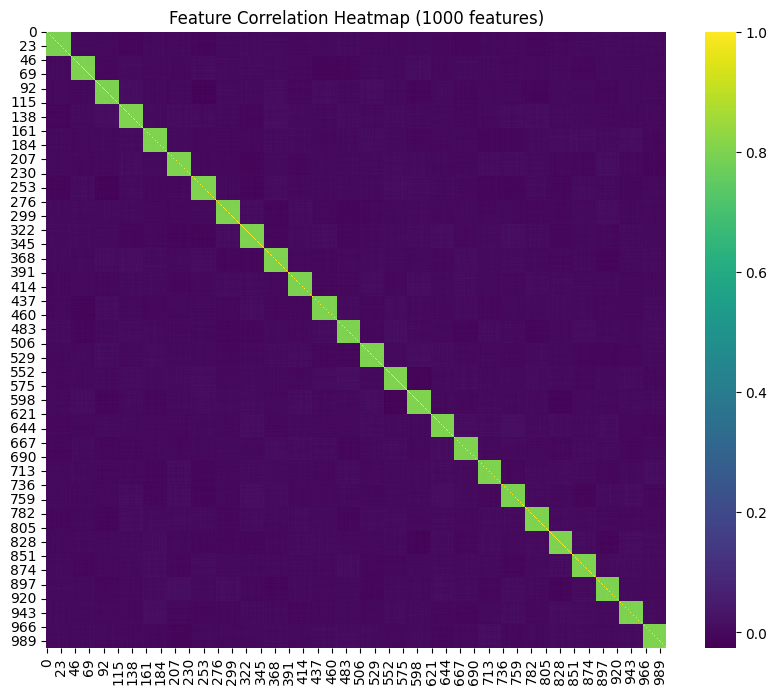


Splitting into train/test sets (80%/20%)...
Training set: (24000, 1000), Testing set: (6000, 1000)

Initializing Keras-based IGTDCNNRegressor...
Initializing PyTorch-based IGTDCNNRegressor...

Fitting Keras-based pipeline...
[fit - initial] X.shape=(24000, 1000)
[fit - initial] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]

[_select_features - input] X.shape=(24000, 1000)
[_select_features - input] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]

Selected 1000 features using variance with threshold=0.05.
[_select_features - output] X.shape=(24000, 1000)
[_select_features - output] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]

[fit] final selected_features_ = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]
[_build_feature_index_map] => [('A_1', 0), ('A_2', 1), ('A_3', 2), ('A_4', 3), ('A_5', 4)

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100


Training Epochs:   1%|          | 1/100 [00:03<05:36,  3.40s/it]

Train Loss: 251.3967 | Val Loss: 121.9309
Validation loss improved; model saved at best_model_regressor.pth

Epoch 2/100


Training Epochs:   2%|▏         | 2/100 [00:05<04:06,  2.52s/it]

Train Loss: 162.3581 | Val Loss: 108.4482
Validation loss improved; model saved at best_model_regressor.pth

Epoch 3/100


Training Epochs:   3%|▎         | 3/100 [00:07<03:37,  2.24s/it]

Train Loss: 153.5046 | Val Loss: 211.2337
No improvement (1 epoch).

Epoch 4/100


Training Epochs:   4%|▍         | 4/100 [00:09<03:21,  2.10s/it]

Train Loss: 145.4921 | Val Loss: 106.6831
Validation loss improved; model saved at best_model_regressor.pth

Epoch 5/100


Training Epochs:   5%|▌         | 5/100 [00:10<03:11,  2.02s/it]

Train Loss: 142.2937 | Val Loss: 97.9719
Validation loss improved; model saved at best_model_regressor.pth

Epoch 6/100


Training Epochs:   6%|▌         | 6/100 [00:12<03:05,  1.98s/it]

Train Loss: 147.0531 | Val Loss: 97.2775
Validation loss improved; model saved at best_model_regressor.pth

Epoch 7/100


Training Epochs:   7%|▋         | 7/100 [00:14<03:01,  1.95s/it]

Train Loss: 146.2656 | Val Loss: 82.0757
Validation loss improved; model saved at best_model_regressor.pth

Epoch 8/100


Training Epochs:   8%|▊         | 8/100 [00:16<02:57,  1.93s/it]

Train Loss: 139.8061 | Val Loss: 85.5568
No improvement (1 epoch).

Epoch 9/100


Training Epochs:   9%|▉         | 9/100 [00:18<02:55,  1.93s/it]

Train Loss: 137.6839 | Val Loss: 100.8151
No improvement (2 epochs).

Epoch 10/100


Training Epochs:  10%|█         | 10/100 [00:20<02:52,  1.92s/it]

Train Loss: 137.2927 | Val Loss: 85.7420
No improvement (3 epochs).

Epoch 11/100


Training Epochs:  11%|█         | 11/100 [00:22<02:49,  1.91s/it]

Train Loss: 135.4559 | Val Loss: 76.9766
Validation loss improved; model saved at best_model_regressor.pth

Epoch 12/100


Training Epochs:  12%|█▏        | 12/100 [00:24<02:46,  1.90s/it]

Train Loss: 134.0933 | Val Loss: 75.8984
Validation loss improved; model saved at best_model_regressor.pth

Epoch 13/100


Training Epochs:  13%|█▎        | 13/100 [00:26<02:44,  1.89s/it]

Train Loss: 126.1437 | Val Loss: 86.6553
No improvement (1 epoch).

Epoch 14/100


Training Epochs:  14%|█▍        | 14/100 [00:28<02:43,  1.90s/it]

Train Loss: 128.9704 | Val Loss: 92.8594
No improvement (2 epochs).

Epoch 15/100


Training Epochs:  15%|█▌        | 15/100 [00:29<02:42,  1.91s/it]

Train Loss: 125.2713 | Val Loss: 79.5934
No improvement (3 epochs).

Epoch 16/100


Training Epochs:  16%|█▌        | 16/100 [00:31<02:40,  1.92s/it]

Train Loss: 125.8916 | Val Loss: 85.9347
No improvement (4 epochs).

Epoch 17/100


Training Epochs:  17%|█▋        | 17/100 [00:33<02:38,  1.91s/it]

Train Loss: 122.9369 | Val Loss: 172.0243
No improvement (5 epochs).

Epoch 18/100


Training Epochs:  18%|█▊        | 18/100 [00:35<02:35,  1.90s/it]

Train Loss: 123.7230 | Val Loss: 75.9894
No improvement (6 epochs).

Epoch 19/100


Training Epochs:  19%|█▉        | 19/100 [00:37<02:34,  1.91s/it]

Train Loss: 120.4340 | Val Loss: 108.6861
No improvement (7 epochs).

Epoch 20/100


Training Epochs:  20%|██        | 20/100 [00:39<02:31,  1.89s/it]

Train Loss: 124.7166 | Val Loss: 78.0449
No improvement (8 epochs).

Epoch 21/100


Training Epochs:  21%|██        | 21/100 [00:41<02:30,  1.90s/it]

Train Loss: 117.4780 | Val Loss: 97.6734
No improvement (9 epochs).

Epoch 22/100


Training Epochs:  21%|██        | 21/100 [00:43<02:42,  2.06s/it]

Train Loss: 119.8648 | Val Loss: 89.4924
No improvement (10 epochs).
Early stopping triggered.
PyTorch pipeline training time: 8168.98s.

[transform - initial] X.shape=(6000, 1000)
[transform - initial] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]



[transform - initial] X.shape=(6000, 1000)
[transform - initial] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]

Keras IGTDCNN => R²: 0.9435, MSE: 67.3813
PyTorch IGTDCNN => R²: 0.9432, MSE: 67.7745

Fitting RandomForestRegressor (n_estimators=300) as a benchmark...
RandomForest => R²: 0.6689, MSE: 394.8081, train_time: 8467.47s

Comparison of results:


,Model,R²,MSE,TrainTime(s)
0,Keras IGTDCNN,0.943486,67.381340,8207.864059
1,PyTorch IGTDCNN,0.943156,67.774467,8168.981087
2,RandomForest,0.668866,394.808123,8467.472260



Visualizing IGTDTransformer images for 3 training samples.
Highlighting these features: ['B_4', 'D_24', 'K_8', 'O_31', 'T_33']

Keras pipeline images:
[transform - initial] X.shape=(3, 1000)
[transform - initial] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]



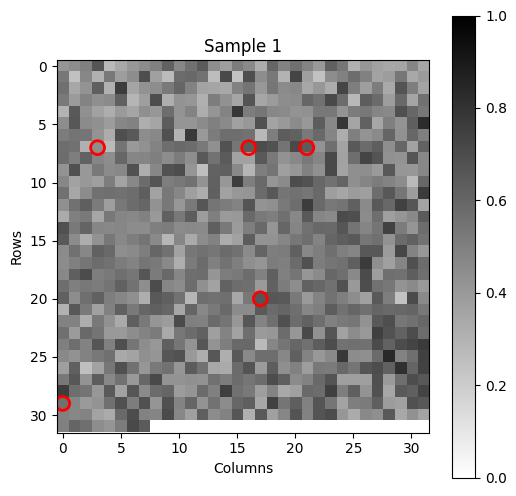

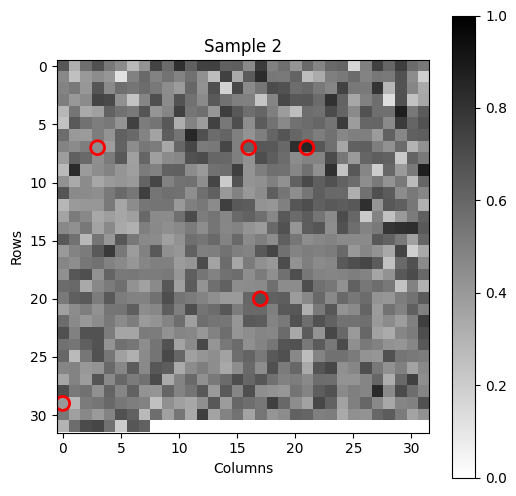

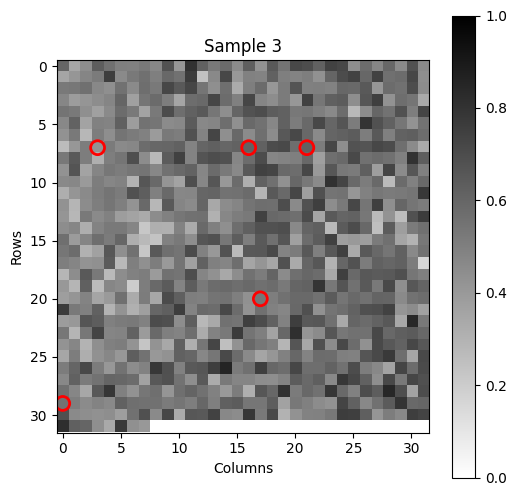


PyTorch pipeline images:
[transform - initial] X.shape=(3, 1000)
[transform - initial] X.columns=['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', ('...', '...')]



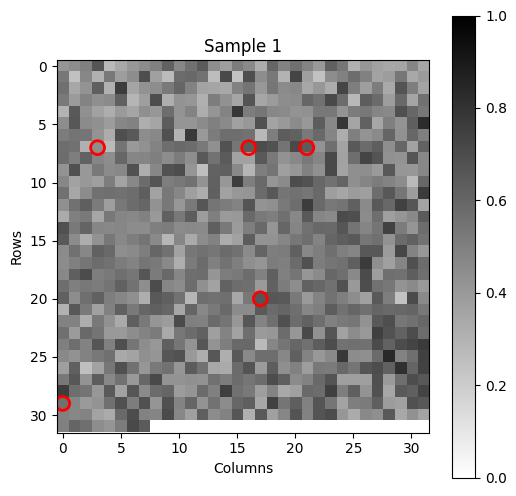

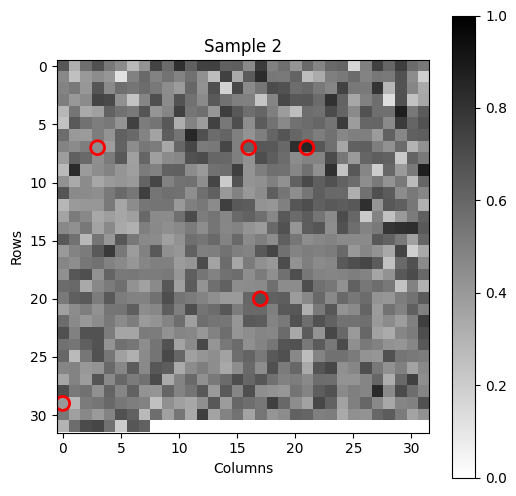

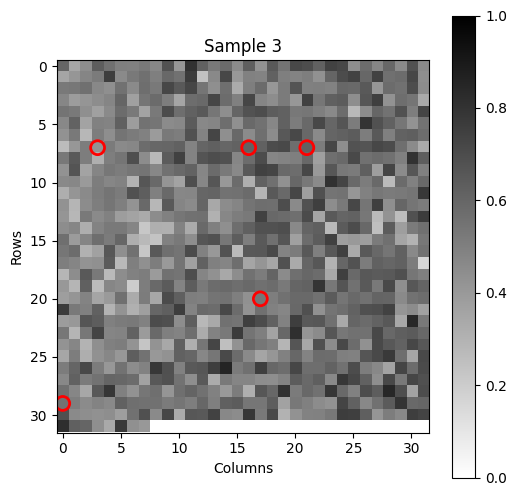


Plotting predicted vs. actual for each model...


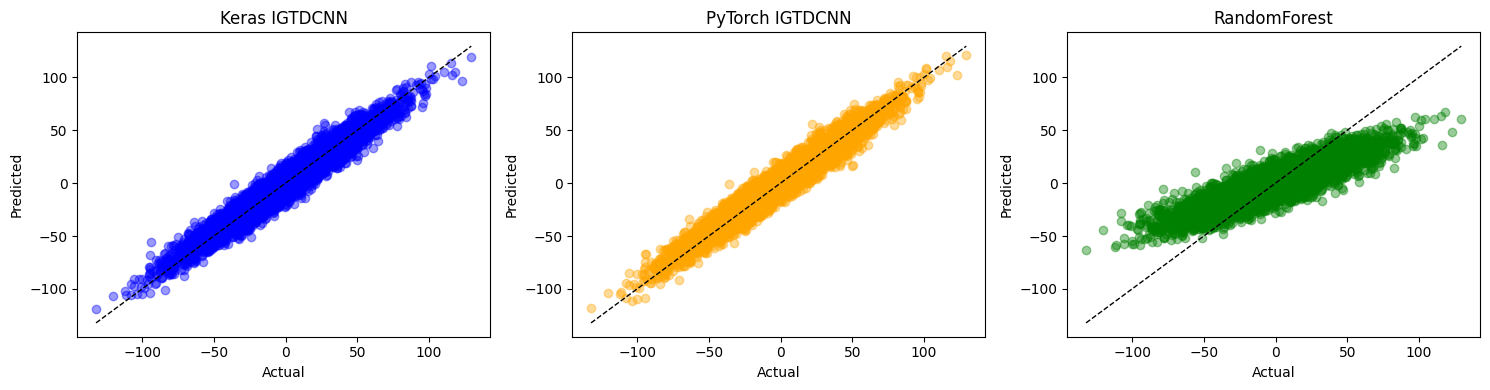

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


def main():
    """
    Demonstration workflow that generates a synthetic regression dataset with:
      - 30,000 samples
      - 1,000 features distributed across 26 correlated blocks (A–Z)
      - A regression target that is a linear combination of 100 randomly selected features plus noise

    We then compare performance between:
      - Keras-based IGTDCNNRegressor
      - PyTorch-based IGTDCNNRegressor
      - RandomForestRegressor benchmark

    We also visualize the correlation matrix and show IGTD-transformed images for
    a few training samples, highlighting a subset of features used in the target.
    """

    print("1) Generating synthetic data with 30k samples and 1k correlated features...")

    # ---------- Step 1: Data Generation ----------
    def generate_block_cov(size, rho=0.8):
        """
        Create a 'size x size' covariance matrix with diagonal=1 and off-diagonal=rho,
        forming a strongly correlated block.
        """
        cov_block = np.full((size, size), rho)
        np.fill_diagonal(cov_block, 1.0)
        return cov_block

    # 26 letters => 26 blocks
    letters = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # 'A'..'Z'
    # Distribute 1,000 features across these 26 blocks
    # Our approach: first 12 blocks of size 39 => total 468, then 14 blocks of size 38 => total 532 => sum=1000
    block_sizes = [39] * 12 + [38] * 14
    assert sum(block_sizes) == 1000, "Block sizes must sum to 1000"

    n_samples = 30000
    rng = np.random.default_rng(42)  # reproducible random generator

    # Build block-diagonal covariance
    blocks = [generate_block_cov(sz, rho=0.8) for sz in block_sizes]
    cov_full = block_diag(*blocks)
    mean_vec = np.zeros(sum(block_sizes))

    # Sample from multivariate normal
    X_raw = rng.multivariate_normal(mean_vec, cov_full, size=n_samples)

    # Name the features using letters, e.g., 'A_1'..'A_39', 'B_1'..'B_39', ...
    feature_names = []
    idx_start = 0
    for i, letter in enumerate(letters):
        sz = block_sizes[i]
        for j in range(1, sz + 1):
            feature_names.append(f"{letter}_{j}")
        idx_start += sz

    # ---------- Step 2: Define the Target (linear combo of 100 random features) ----------
    # Randomly pick 100 distinct feature indices
    target_indices = rng.choice(1000, size=100, replace=False)

    # Assign random coefficients to each chosen feature
    target_coefs = rng.uniform(0.5, 3.0, size=100)  # e.g. 0.5 ~ 3.0

    # Add noise
    noise = rng.normal(0, 3.0, size=n_samples)

    # y = sum of (coefs[i] * X[:, feature_idx]) + noise
    y = np.zeros(n_samples, dtype=np.float32)
    for feat_idx, coef in zip(target_indices, target_coefs):
        y += coef * X_raw[:, feat_idx]
    y += noise

    # Create a DataFrame
    df = pd.DataFrame(X_raw, columns=feature_names)
    print(f"DataFrame shape: {df.shape}")
    display(df.head(10))

    # ---------- Step 3: Data Exploration ----------
    print(f"\nNumber of features: {df.shape[1]}")
    print("First few feature names:", feature_names[:5], "...")
    print("Last few feature names:", feature_names[-5:])

    print("\nComputing correlation matrix for all 1,000 features (this may take a moment)...")
    t0_corr = time.time()
    corr_matrix = df.corr().values
    t1_corr = time.time()
    print(f"Correlation computed in {t1_corr - t0_corr:.2f} s. Shape: {corr_matrix.shape}")

    print("Plotting correlation heatmap of size 1000x1000...")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='viridis')
    plt.title("Feature Correlation Heatmap (1000 features)")
    plt.show()

    # ---------- Step 4: Train/Test Split ----------
    print("\nSplitting into train/test sets (80%/20%)...")
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

    # ---------- Step 5: IGTDTransformer parameters ----------
    transformer_params = {
        'image_size': (32, 32),              # 32x32 = 1024 pixels, enough for 1000 features
        'feature_selection': 'variance',
        'feature_selection_threshold': 0.05,
        'feature_distance': 'euclidean',
        'pixel_distance': 'euclidean',
        'error_measure': 'squared',
        'max_iterations': 3000,
        'tolerance': 1e-4
    }

    # ---------- Step 6: Common CNN Regressor Params ----------
    cnn_regressor_params = {
        'input_shape': (32, 32, 1),
        'num_conv_layers': 2,
        'num_filters': [32, 64],
        'kernel_sizes': [3, 3],
        'activation': 'relu',
        'use_batch_norm': True,
        'dropout_rate': 0.5,
        'optimizer': 'adamw',
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'epochs': 100,
        'batch_size': 32,
        'validation_split': 0.2,
        'early_stopping_patience': 10,
    }

    # ---------- Step 7: Create two IGTDCNNRegressors (Keras & PyTorch) ----------
    print("\nInitializing Keras-based IGTDCNNRegressor...")
    igt_cnn_keras = IGTDCNNRegressor(
        backend='keras',
        transformer_params=transformer_params,
        regressor_params=cnn_regressor_params,
        random_state=42,
        verbose=True
    )

    print("Initializing PyTorch-based IGTDCNNRegressor...")
    igt_cnn_pytorch = IGTDCNNRegressor(
        backend='pytorch',
        transformer_params=transformer_params,
        regressor_params=cnn_regressor_params,
        random_state=42,
        verbose=True
    )

    # ---------- Step 8: Build pipelines ----------
    pipeline_keras = Pipeline([
        ('IGTDCNN_Keras', igt_cnn_keras)
    ])

    pipeline_pytorch = Pipeline([
        ('IGTDCNN_PyTorch', igt_cnn_pytorch)
    ])

    # ---------- Step 9: Fit Keras pipeline ----------
    print("\nFitting Keras-based pipeline...")
    start_keras = time.time()
    pipeline_keras.fit(X_train, y_train)
    keras_time = time.time() - start_keras
    print(f"Keras pipeline training time: {keras_time:.2f}s.\n")

    # ---------- Step 10: Fit PyTorch pipeline ----------
    print("Fitting PyTorch-based pipeline...")
    start_pytorch = time.time()
    pipeline_pytorch.fit(X_train, y_train)
    pytorch_time = time.time() - start_pytorch
    print(f"PyTorch pipeline training time: {pytorch_time:.2f}s.\n")

    # ---------- Step 11: Predictions ----------
    y_pred_keras = pipeline_keras.predict(X_test)
    y_pred_pytorch = pipeline_pytorch.predict(X_test)

    r2_keras = r2_score(y_test, y_pred_keras)
    mse_keras = mean_squared_error(y_test, y_pred_keras)
    r2_pytorch = r2_score(y_test, y_pred_pytorch)
    mse_pytorch = mean_squared_error(y_test, y_pred_pytorch)

    print(f"Keras IGTDCNN => R²: {r2_keras:.4f}, MSE: {mse_keras:.4f}")
    print(f"PyTorch IGTDCNN => R²: {r2_pytorch:.4f}, MSE: {mse_pytorch:.4f}\n")

    # ---------- Step 12: RandomForest benchmark ----------
    print("Fitting RandomForestRegressor (n_estimators=300) as a benchmark...")
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    start_rf = time.time()
    rf.fit(X_train, y_train)
    rf_time = time.time() - start_rf

    y_pred_rf = rf.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    print(f"RandomForest => R²: {r2_rf:.4f}, MSE: {mse_rf:.4f}, train_time: {rf_time:.2f}s\n")

    # ---------- Step 13: Compare Results ----------
    comparison_df = pd.DataFrame({
        'Model': ['Keras IGTDCNN', 'PyTorch IGTDCNN', 'RandomForest'],
        'R²': [r2_keras, r2_pytorch, r2_rf],
        'MSE': [mse_keras, mse_pytorch, mse_rf],
        'TrainTime(s)': [keras_time, pytorch_time, rf_time]
    })
    print("Comparison of results:")
    display(comparison_df)

    # ---------- Step 14: Visualize IGTD images ----------
    print("\nVisualizing IGTDTransformer images for 3 training samples.")
    # Highlight the first 5 features that contributed to the target
    highlight_indices = sorted(target_indices[:5])  # pick 5 smallest
    highlight_features = [feature_names[i] for i in highlight_indices]
    print("Highlighting these features:", highlight_features)

    # Keras pipeline images
    keras_transformer = pipeline_keras.named_steps['IGTDCNN_Keras'].transformer_
    sample_keras = X_train.iloc[:3, :]  # first 3 samples
    print("\nKeras pipeline images:")
    keras_transformer.plot_transformed_images(
        samples=sample_keras,
        num_samples=3,
        highlight_features=highlight_features,
        annotate=False
    )

    # PyTorch pipeline images
    pytorch_transformer = pipeline_pytorch.named_steps['IGTDCNN_PyTorch'].transformer_
    sample_pytorch = X_train.iloc[:3, :]
    print("\nPyTorch pipeline images:")
    pytorch_transformer.plot_transformed_images(
        samples=sample_pytorch,
        num_samples=3,
        highlight_features=highlight_features,
        annotate=False
    )

    # ---------- Step 15: Plot predicted vs. actual ----------
    print("\nPlotting predicted vs. actual for each model...")
    plt.figure(figsize=(15, 4))

    # Keras
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_keras, alpha=0.4, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.title('Keras IGTDCNN')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # PyTorch
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, y_pred_pytorch, alpha=0.4, color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.title('PyTorch IGTDCNN')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # RandomForest
    plt.subplot(1, 3, 3)
    plt.scatter(y_test, y_pred_rf, alpha=0.4, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.title('RandomForest')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# KerasCNNClassifier

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import check_X_y, check_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
)
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import os


class KerasCNNClassifier(BaseEstimator, ClassifierMixin):
    """
    Keras CNN classifier with scikit-learn API compliance.

    This class trains a convolutional neural network to perform multi-class
    classification on image data.

    Parameters
    ----------
    n_classes : int, default=2
        Number of output classes.

    input_shape : tuple of int, default=(50, 50, 1)
        Shape of input images as (rows, columns, channels).

    num_conv_layers : int, default=2
        Number of convolutional layers.

    num_filters : list of int, default=[32, 64]
        Number of filters for each convolutional layer. Must match `num_conv_layers`.

    kernel_sizes : list of int, default=[3, 3]
        Kernel sizes for each convolutional layer. Must match `num_conv_layers`.

    activation : str, default='relu'
        Convolution activation function. Options: 'relu', 'leaky_relu'.

    use_batch_norm : bool, default=True
        Whether to include batch normalization after convolutional layers.

    dropout_rate : float, default=0.5
        Dropout rate in fully connected layer(s).

    optimizer : str, default='adamw'
        Training optimizer. Options: 'adamw', 'adam', 'sgd', etc.

    learning_rate : float, default=1e-3
        Learning rate for the optimizer.

    weight_decay : float, default=1e-4
        L2 regularization factor.

    epochs : int, default=100
        Number of training epochs.

    batch_size : int, default=32
        Batch size for training.

    validation_split : float, default=0.2
        Fraction of data reserved for validation.

    early_stopping_patience : int, default=10
        Early stopping patience (no improvement => stop).

    tolerance : float, default=1e-4
        Minimum change in the monitored quantity to qualify as an improvement.

    model_checkpoint_path : str, default='best_model_classifier.keras'
        File path to save best model.
        - If ends with '.h5', saves in HDF5; else TensorFlow SavedModel format.

    random_state : int or None, default=None
        Random seed for reproducibility.

    verbose : int, default=1
        Keras training verbosity (0=silent,1=bar,2=line/epoch).

    lr_scheduler_patience : int, default=5
        Patience for ReduceLROnPlateau scheduling.

    lr_scheduler_factor : float, default=0.1
        Factor to reduce LR on plateau.

    lr_scheduler_min_lr : float, default=1e-6
        Lower bound on LR.

    Attributes
    ----------
    model_ : tensorflow.keras.Model
        Compiled Keras model instance.

    trained_ : bool
        Indicates whether `.fit()` completed successfully.

    best_model_path_ : str
        File path to the best saved model checkpoint.
    """

    def __init__(self,
                 n_classes=2,
                 input_shape=(50, 50, 1),
                 num_conv_layers=2,
                 num_filters=[32, 64],
                 kernel_sizes=[3, 3],
                 activation='relu',
                 use_batch_norm=True,
                 dropout_rate=0.5,
                 optimizer='adamw',
                 learning_rate=1e-3,
                 weight_decay=1e-4,
                 epochs=100,
                 batch_size=32,
                 validation_split=0.2,
                 early_stopping_patience=10,
                 tolerance=1e-4,
                 model_checkpoint_path='best_model_classifier.keras',
                 random_state=None,
                 verbose=1,
                 lr_scheduler_patience=5,
                 lr_scheduler_factor=0.1,
                 lr_scheduler_min_lr=1e-6):

        # Primary hyperparameters
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.num_conv_layers = num_conv_layers
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.activation = activation
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.early_stopping_patience = early_stopping_patience
        self.tolerance = tolerance
        self.model_checkpoint_path = model_checkpoint_path
        self.random_state = random_state
        self.verbose = verbose

        # LR scheduler parameters
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_min_lr = lr_scheduler_min_lr

        # Internal attributes
        self.model_ = None
        self.trained_ = False
        self.best_model_path_ = None

        # Input validation
        if len(self.num_filters) != self.num_conv_layers:
            raise ValueError("Length of num_filters must match num_conv_layers.")
        if len(self.kernel_sizes) != self.num_conv_layers:
            raise ValueError("Length of kernel_sizes must match num_conv_layers.")

    def fit(self, X, y):
        """
        Fit the CNN classifier to the data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        y : array-like, shape (n_samples,)
            Integer class labels (0 .. n_classes-1).

        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Validate and convert data
        X, y = check_X_y(X, y, ensure_min_samples=2, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int64)

        # Set seeds
        if self.random_state is not None:
            np.random.seed(self.random_state)
            tf.random.set_seed(self.random_state)

        # Build model if needed
        if self.model_ is None:
            self.model_ = self._build_model()

        # Prepare callbacks
        callbacks = []

        # Early stopping
        es_callback = EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_patience,
            restore_best_weights=True,
            verbose=self.verbose
        )
        callbacks.append(es_callback)

        # Model checkpoint
        checkpoint_dir = os.path.dirname(self.model_checkpoint_path)
        if checkpoint_dir and not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        mc_callback = ModelCheckpoint(
            self.model_checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=self.verbose
        )
        callbacks.append(mc_callback)

        # LR scheduler on plateau
        lr_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=self.lr_scheduler_factor,
            patience=self.lr_scheduler_patience,
            min_lr=self.lr_scheduler_min_lr,
            verbose=self.verbose
        )
        callbacks.append(lr_callback)

        # Compile model
        opt_instance = self._get_optimizer()
        self.model_.compile(
            optimizer=opt_instance,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train model
        _ = self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.validation_split,
            callbacks=callbacks,
            verbose=self.verbose
        )

        # Save the best model path and reload best weights
        self.best_model_path_ = self.model_checkpoint_path
        self.model_ = load_model(self.best_model_path_)
        self.trained_ = True

        return self

    def predict(self, X):
        """
        Predict class labels for the given input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        Returns
        -------
        preds : array-like, shape (n_samples,)
            Predicted class labels.
        """
        if not self.trained_:
            raise RuntimeError("Must fit the classifier before predicting.")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)
        if X.ndim != 4:
            raise ValueError("Expected X to be 4D: (samples, rows, cols, channels).")

        # Predict class probabilities
        proba = self.model_.predict(X, batch_size=self.batch_size, verbose=0)
        # Argmax -> class indices
        preds = np.argmax(proba, axis=1)
        return preds

    def predict_proba(self, X):
        """
        Predict class probabilities for the given input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.

        Returns
        -------
        proba : array-like, shape (n_samples, n_classes)
            Predicted probability for each class.
        """
        if not self.trained_:
            raise RuntimeError("Must fit the classifier before predicting probabilities.")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)
        if X.ndim != 4:
            raise ValueError("Expected X to be 4D: (samples, rows, cols, channels).")

        return self.model_.predict(X, batch_size=self.batch_size, verbose=0)

    def score(self, X, y):
        """
        Return classification accuracy on given data and labels.

        Parameters
        ----------
        X : array-like, shape (n_samples, rows, cols, channels)
            Image data.
        y : array-like, shape (n_samples,)
            True class labels.

        Returns
        -------
        accuracy : float
            Classification accuracy (0.0 - 1.0).
        """
        preds = self.predict(X)
        return accuracy_score(y, preds)

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        """
        return {
            'n_classes': self.n_classes,
            'input_shape': self.input_shape,
            'num_conv_layers': self.num_conv_layers,
            'num_filters': self.num_filters,
            'kernel_sizes': self.kernel_sizes,
            'activation': self.activation,
            'use_batch_norm': self.use_batch_norm,
            'dropout_rate': self.dropout_rate,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'validation_split': self.validation_split,
            'early_stopping_patience': self.early_stopping_patience,
            'tolerance': self.tolerance,
            'model_checkpoint_path': self.model_checkpoint_path,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'lr_scheduler_patience': self.lr_scheduler_patience,
            'lr_scheduler_factor': self.lr_scheduler_factor,
            'lr_scheduler_min_lr': self.lr_scheduler_min_lr
        }

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _build_model(self):
        """
        Build a CNN model for multi-class classification.
        """
        inputs = Input(shape=self.input_shape)
        x = inputs

        # Activation choice mapping
        activation_mapping = {
            'relu': 'relu',
            'leaky_relu': tf.keras.layers.LeakyReLU(negative_slope=0.01)  # Default alpha
        }

        if self.activation.lower() not in activation_mapping:
            raise ValueError(f"Unsupported activation: {self.activation}")

        act_fn = activation_mapping[self.activation.lower()]

        # Add convolutional layers
        for i in range(self.num_conv_layers):
            x = Conv2D(
                filters=self.num_filters[i],
                kernel_size=self.kernel_sizes[i],
                padding='same',
                kernel_regularizer=l2(self.weight_decay)
            )(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            # Apply activation
            if isinstance(act_fn, tf.keras.layers.Layer):
                # For activations like LeakyReLU
                x = act_fn(x)
            else:
                # For string-based activations like 'relu'
                x = Activation(act_fn)(x)

            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Flatten -> Dense -> Dropout
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=l2(self.weight_decay))(x)

        # Apply activation
        if isinstance(act_fn, tf.keras.layers.Layer):
            x = act_fn(x)
        else:
            x = Activation(act_fn)(x)

        x = Dropout(self.dropout_rate)(x)

        # Final classification layer with softmax activation
        outputs = Dense(self.n_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def _get_optimizer(self):
        """
        Return the appropriate optimizer, applying weight decay if possible.
        """
        opt = self.optimizer.lower()
        lr = self.learning_rate

        if opt == 'adamw':
            return AdamW(learning_rate=lr, weight_decay=self.weight_decay)
        elif opt == 'adam':
            return Adam(learning_rate=lr, weight_decay=self.weight_decay)
        elif opt == 'sgd':
            return SGD(learning_rate=lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

# PyTorchCNNClassifier

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from tqdm import tqdm
import copy
import os
import warnings


class PyTorchCNNClassifier(BaseEstimator, ClassifierMixin):
    """
    PyTorch CNN classifier following scikit-learn's API style.

    This classifier trains a convolutional neural network on image data
    (n_samples, rows, cols, channels) for a multi-class classification task.

    Parameters
    ----------
    n_classes : int, default=2
        Number of distinct output classes.

    input_shape : tuple of int, default=(50, 50, 1)
        Shape of the input images (rows, columns, channels).

    num_conv_layers : int, default=2
        Number of convolutional layers in the CNN.

    num_filters : list of int, default=[32, 64]
        Number of filters for each convolutional layer; length must match `num_conv_layers`.

    kernel_sizes : list of int, default=[3, 3]
        Kernel sizes for the convolutional layers; length must match `num_conv_layers`.

    activation : str, default='relu'
        Activation function. Supported options: 'relu', 'leaky_relu'.

    use_batch_norm : bool, default=True
        Whether to include batch normalization after convolutional layers.

    dropout_rate : float, default=0.5
        Dropout rate in the fully connected layers.

    optimizer : str, default='adamw'
        Optimizer type: 'adamw', 'adam', or 'sgd'.

    learning_rate : float, default=1e-3
        Initial learning rate for the optimizer.

    weight_decay : float, default=1e-4
        Weight decay (L2 regularization) factor.

    epochs : int, default=20
        Maximum number of training epochs.

    batch_size : int, default=32
        Batch size for training.

    validation_split : float, default=0.2
        Fraction of training data used for validation.

    early_stopping_patience : int, default=10
        Number of epochs without validation improvement to allow before stopping.

    tolerance : float, default=1e-4
        Minimum change in the monitored quantity to qualify as an improvement.

    model_checkpoint_path : str, default='best_model_classifier.pth'
        File path to save the best model weights.

    random_state : int or None, default=None
        Random seed for reproducibility.

    verbose : bool, default=False
        If True, prints progress updates during training.

    use_lr_scheduler : bool, default=False
        If True, uses ReduceLROnPlateau to decrease LR on val-loss plateau.

    lr_scheduler_patience : int, default=2
        Patience for LR scheduler.

    lr_scheduler_factor : float, default=0.1
        Factor for reducing LR.

    lr_scheduler_cooldown : int, default=0
        Cooldown epochs for LR scheduler.

    lr_scheduler_min_lr : float, default=1e-6
        Minimum LR allowed by the scheduler.

    Attributes
    ----------
    model_ : torch.nn.Module
        The PyTorch CNN model for classification.

    device_ : torch.device
        Device (CPU or GPU) used for training/prediction.

    trained_ : bool
        True if the model has been trained at least once.

    best_model_state_ : dict
        A copy of the best model state dictionary found during training.
    """

    def __init__(self,
                 n_classes=2,
                 input_shape=(50, 50, 1),
                 num_conv_layers=2,
                 num_filters=[32, 64],
                 kernel_sizes=[3, 3],
                 activation='relu',
                 use_batch_norm=True,
                 dropout_rate=0.5,
                 optimizer='adamw',
                 learning_rate=1e-3,
                 weight_decay=1e-4,
                 epochs=20,
                 batch_size=32,
                 validation_split=0.2,
                 early_stopping_patience=10,
                 tolerance=1e-4,
                 model_checkpoint_path='best_model_classifier.pth',
                 random_state=None,
                 verbose=False,
                 use_lr_scheduler=False,
                 lr_scheduler_patience=2,
                 lr_scheduler_factor=0.1,
                 lr_scheduler_cooldown=0,
                 lr_scheduler_min_lr=1e-6):

        # Primary hyperparameters
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.num_conv_layers = num_conv_layers
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.activation = activation
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.early_stopping_patience = early_stopping_patience
        self.tolerance = tolerance
        self.model_checkpoint_path = model_checkpoint_path
        self.random_state = random_state
        self.verbose = verbose

        # LR scheduler parameters
        self.use_lr_scheduler = use_lr_scheduler
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_cooldown = lr_scheduler_cooldown
        self.lr_scheduler_min_lr = lr_scheduler_min_lr

        # Internal attributes
        self.model_ = None
        self.device_ = None
        self.trained_ = False
        self.best_model_state_ = None

    def fit(self, X, y):
        """
        Fit the CNN classifier to the data.

        Parameters
        ----------
        X : array-like of shape (n_samples, rows, columns, channels)
            Input image data.

        y : array-like of shape (n_samples,)
            Class labels.

        Returns
        -------
        self : object
            Fitted classifier instance.
        """
        # Check and convert X, y
        X, y = check_X_y(X, y, ensure_min_samples=2, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int64)  # for classification

        # Set random seeds
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)

        # Choose device
        self.device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.verbose:
            print(f"Using device: {self.device_}")

        # Create datasets
        tensor_X = torch.from_numpy(X).permute(0, 3, 1, 2)  # (N, C, H, W)
        tensor_y = torch.from_numpy(y)                      # (N,)
        dataset = TensorDataset(tensor_X, tensor_y)

        # Train/val split
        n_total = len(dataset)
        n_val = int(n_total * self.validation_split)
        n_train = n_total - n_val
        train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        # Build model
        if self.model_ is None:
            self.model_ = self._build_model()
        self.model_.to(self.device_)

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = self._get_optimizer()

        # Optional LR scheduler
        scheduler = None
        if self.use_lr_scheduler:
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=self.lr_scheduler_factor,
                patience=self.lr_scheduler_patience,
                cooldown=self.lr_scheduler_cooldown,
                min_lr=self.lr_scheduler_min_lr,
                verbose=self.verbose
            )

        best_val_loss = np.inf
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(self.model_.state_dict())

        # Ensure checkpoint directory
        checkpoint_dir = os.path.dirname(self.model_checkpoint_path)
        if checkpoint_dir and not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        # Main training loop
        for epoch in tqdm(range(self.epochs), disable=not self.verbose, desc="Training Epochs"):
            if self.verbose:
                print(f"\nEpoch {epoch + 1}/{self.epochs}")

            # --- Training ---
            self.model_.train()
            train_losses = []
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device_)
                batch_y = batch_y.to(self.device_)

                optimizer.zero_grad()
                outputs = self.model_(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            # --- Validation ---
            self.model_.eval()
            val_losses = []
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X = batch_X.to(self.device_)
                    batch_y = batch_y.to(self.device_)

                    outputs = self.model_(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_losses.append(loss.item())

            avg_train_loss = np.mean(train_losses)
            avg_val_loss = np.mean(val_losses)

            if self.verbose:
                print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

            # LR scheduler step
            if scheduler is not None:
                scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss - self.tolerance:
                best_val_loss = avg_val_loss
                best_model_wts = copy.deepcopy(self.model_.state_dict())
                epochs_no_improve = 0
                # Save best model
                torch.save(self.model_.state_dict(), self.model_checkpoint_path)
                if self.verbose:
                    print(f"Validation loss improved; model saved at {self.model_checkpoint_path}")
            else:
                epochs_no_improve += 1
                if self.verbose:
                    print(f"No improvement ({epochs_no_improve} epoch{'s' if epochs_no_improve > 1 else ''}).")
                if epochs_no_improve >= self.early_stopping_patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        # Load best model weights
        self.model_.load_state_dict(best_model_wts)
        self.trained_ = True
        return self

    def predict(self, X):
        """
        Predict class labels for the given input data.

        Parameters
        ----------
        X : array-like of shape (n_samples, rows, columns, channels)
            Input image data.

        Returns
        -------
        preds : ndarray of shape (n_samples,)
            Predicted class labels.
        """
        if not self.trained_:
            raise RuntimeError("You must train the classifier before predicting!")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)

        tensor_X = torch.from_numpy(X).permute(0, 3, 1, 2).to(self.device_)
        self.model_.eval()
        with torch.no_grad():
            logits = self.model_(tensor_X)  # shape: (N, n_classes)
        preds = torch.argmax(logits, dim=1)
        return preds.cpu().numpy()

    def predict_proba(self, X):
        """
        Predict class probabilities for the given input data.

        Parameters
        ----------
        X : array-like of shape (n_samples, rows, columns, channels)
            Input image data.

        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not self.trained_:
            raise RuntimeError("You must train the classifier before predicting probabilities!")

        X = check_array(X, ensure_min_samples=1, allow_nd=True)
        X = np.asarray(X, dtype=np.float32)

        tensor_X = torch.from_numpy(X).permute(0, 3, 1, 2).to(self.device_)
        self.model_.eval()
        with torch.no_grad():
            logits = self.model_(tensor_X)    # shape: (N, n_classes)
            proba = nn.Softmax(dim=1)(logits) # convert logits to probabilities
        return proba.cpu().numpy()

    def score(self, X, y):
        """
        Compute the accuracy on given data and labels.

        Parameters
        ----------
        X : array-like of shape (n_samples, rows, columns, channels)
            Input image data.
        y : array-like of shape (n_samples,)
            True class labels.

        Returns
        -------
        float
            The classification accuracy.
        """
        preds = self.predict(X)
        correct = np.sum(preds == y)
        total = len(y)
        return correct / total

    def get_params(self, deep=True):
        """
        Return parameters for external usage, e.g. in GridSearchCV.
        """
        return {
            'n_classes': self.n_classes,
            'input_shape': self.input_shape,
            'num_conv_layers': self.num_conv_layers,
            'num_filters': self.num_filters,
            'kernel_sizes': self.kernel_sizes,
            'activation': self.activation,
            'use_batch_norm': self.use_batch_norm,
            'dropout_rate': self.dropout_rate,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'validation_split': self.validation_split,
            'early_stopping_patience': self.early_stopping_patience,
            'tolerance': self.tolerance,
            'model_checkpoint_path': self.model_checkpoint_path,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'use_lr_scheduler': self.use_lr_scheduler,
            'lr_scheduler_patience': self.lr_scheduler_patience,
            'lr_scheduler_factor': self.lr_scheduler_factor,
            'lr_scheduler_cooldown': self.lr_scheduler_cooldown,
            'lr_scheduler_min_lr': self.lr_scheduler_min_lr
        }

    def set_params(self, **params):
        """
        Set parameters for the estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _build_model(self):
        """
        Build the CNN model with `n_classes` output units for classification.
        """
        layers = []
        in_channels = self.input_shape[2]

        # Activation function mapping
        activation_mapping = {
            'relu': nn.ReLU,
            'leaky_relu': nn.LeakyReLU
        }

        if self.activation.lower() not in activation_mapping:
            raise ValueError(f"Unsupported activation: {self.activation}")

        ActivationClass = activation_mapping[self.activation.lower()]

        # Convolutional layers
        for i in range(self.num_conv_layers):
            out_channels = self.num_filters[i]
            ksize = self.kernel_sizes[i]
            pad = ksize // 2

            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=ksize, padding=pad))
            if self.use_batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(ActivationClass())  # Instantiate a new activation layer
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            in_channels = out_channels

        layers.append(nn.Flatten())

        # Calculate reduced spatial dimensions
        reduced_rows = self.input_shape[0] // (2 ** self.num_conv_layers)
        reduced_cols = self.input_shape[1] // (2 ** self.num_conv_layers)
        if reduced_rows <= 0 or reduced_cols <= 0:
            raise ValueError("Input image size too small for the specified convolutional layers.")

        fc_input_dim = self.num_filters[-1] * reduced_rows * reduced_cols

        # Fully connected layer
        layers.append(nn.Linear(fc_input_dim, 128))
        layers.append(nn.ReLU())  # Use ReLU or consistent activation
        layers.append(nn.Dropout(p=self.dropout_rate))

        # Final classification layer => n_classes output logits
        layers.append(nn.Linear(128, self.n_classes))

        return nn.Sequential(*layers)

    def _get_optimizer(self):
        """
        Initialize the optimizer according to user-specified settings.
        """
        opt = self.optimizer.lower()
        if opt == 'adamw':
            return optim.AdamW(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        elif opt == 'adam':
            return optim.Adam(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        elif opt == 'sgd':
            return optim.SGD(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

# IGTDCNNClassifier

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.metrics import accuracy_score
import warnings


class IGTDCNNClassifier(BaseEstimator, ClassifierMixin):
    """
    IGTDCNNClassifier integrates the IGTDTransformer (tabular-to-image mapping)
    with a selected CNN classifier (Keras or PyTorch) to perform classification
    on tabular data via image representations. Complies with scikit-learn's API.

    Parameters
    ----------
    backend : str, default='keras'
        Backend framework for the CNN classifier: 'keras' or 'pytorch'.

    transformer_params : dict, default=None
        Parameters for IGTDTransformer. If None, defaults are used.

    classifier_params : dict, default=None
        Parameters for the chosen CNN classifier (KerasCNNClassifier or PyTorchCNNClassifier).
        If None, defaults are used.

    random_state : int or None, default=None
        Seed for reproducible random operations.

    verbose : bool, default=False
        If True, prints progress messages during fitting and prediction.

    Attributes
    ----------
    transformer_ : IGTDTransformer
        Fitted IGTDTransformer for tabular-to-image mapping.

    classifier_ : KerasCNNClassifier or PyTorchCNNClassifier
        Fitted CNN classifier for image-based classification.

    fitted_ : bool
        Indicates whether the entire pipeline (transformer + CNN) has been fitted.
    """

    def __init__(self,
                 backend='keras',
                 transformer_params=None,
                 classifier_params=None,
                 random_state=None,
                 verbose=False):
        self.backend = backend.lower()
        self.transformer_params = transformer_params if transformer_params is not None else {}
        self.classifier_params = classifier_params if classifier_params is not None else {}
        self.random_state = random_state
        self.verbose = verbose

        self.transformer_ = None
        self.classifier_ = None
        self.fitted_ = False

    def fit(self, X, y):
        """
        Fit the IGTDCNNClassifier by:
        1) Fitting the IGTDTransformer on tabular data to generate images.
        2) Initializing and fitting a CNN classifier on those images.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            Input tabular data.

        y : array-like, shape (n_samples,)
            Class labels (integers or similar).

        Returns
        -------
        self : IGTDCNNClassifier
            Fitted estimator.
        """
        # Validate and convert input data for classification
        X_cols = X.columns if isinstance(X, pd.DataFrame) else None
        X, y = check_X_y(X, y, ensure_min_samples=2, ensure_all_finite=True)
        X = pd.DataFrame(X, columns=X_cols)  # Ensures IGTDTransformer gets a DataFrame

        # Fit the IGTDTransformer on tabular data
        self.transformer_ = IGTDTransformer(
            random_state=self.random_state,
            verbose=self.verbose,
            **self.transformer_params
        )
        self.transformer_.fit(X, y)

        # Transform tabular data to images
        X_images = self.transformer_.transform(X)

        # Initialize CNN classifier
        if self.backend == 'keras':
            self.classifier_ = KerasCNNClassifier(
                random_state=self.random_state,
                verbose=self.verbose,
                **self.classifier_params
            )
        elif self.backend == 'pytorch':
            self.classifier_ = PyTorchCNNClassifier(
                random_state=self.random_state,
                verbose=self.verbose,
                **self.classifier_params
            )
        else:
            raise ValueError(f"Unsupported backend: {self.backend}. Use 'keras' or 'pytorch'.")

        # Fit CNN classifier on image data
        self.classifier_.fit(X_images, y)

        self.fitted_ = True
        return self

    def predict(self, X):
        """
        Predict class labels for new tabular data by:
        1) Transforming data into images (IGTDTransformer).
        2) Predicting via the CNN classifier.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            New tabular data.

        Returns
        -------
        preds : ndarray of shape (n_samples,)
            Predicted class labels.
        """
        check_is_fitted(self, ['fitted_'])

        if not isinstance(X, pd.DataFrame):
            # Ensure correct columns per transformer's feature_names_
            X = pd.DataFrame(X, columns=self.transformer_.feature_names_)

        # Convert to images
        X_images = self.transformer_.transform(X)

        # Predict with CNN
        return self.classifier_.predict(X_images)

    def predict_proba(self, X):
        """
        Predict class probabilities for new tabular data.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            New tabular data.

        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes)
            Class probability distributions.
        """
        check_is_fitted(self, ['fitted_'])

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.transformer_.feature_names_)

        X_images = self.transformer_.transform(X)

        # If the underlying classifier has predict_proba
        if hasattr(self.classifier_, "predict_proba"):
            return self.classifier_.predict_proba(X_images)
        else:
            raise NotImplementedError(
                "The underlying classifier does not support probability predictions."
            )

    def score(self, X, y):
        """
        Compute accuracy score for the classification task.

        Parameters
        ----------
        X : array-like or pandas.DataFrame, shape (n_samples, n_features)
            Input tabular data.
        y : array-like, shape (n_samples,)
            True class labels.

        Returns
        -------
        accuracy : float
            Classification accuracy (0.0 to 1.0).
        """
        check_is_fitted(self, ['fitted_'])
        preds = self.predict(X)
        return accuracy_score(y, preds)

    def get_params(self, deep=True):
        """
        Retrieve parameters for hyperparameter tuning or cloning.

        Parameters
        ----------
        deep : bool, default=True
            If True, return parameters for subobjects as well.

        Returns
        -------
        params : dict
            Parameter name -> value mapping.
        """
        return {
            'backend': self.backend,
            'transformer_params': self.transformer_params,
            'classifier_params': self.classifier_params,
            'random_state': self.random_state,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """
        Set parameters for reconfiguration or hyperparameter tuning.

        Parameters
        ----------
        params : dict
            Key-value pairs of parameters.

        Returns
        -------
        self : IGTDCNNClassifier
            Updated estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Demonstration

1) Generating synthetic data with 30k samples and 1k correlated features...
DataFrame shape: (30000, 1000)
Head of dataset (including categorical features):


,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,...,Z_29,Z_30,Z_31,Z_32,Z_33,Z_34,Z_35,Z_36,Z_37,Z_38
0,0,-0.757256,-1.159626,0.535413,-0.344856,0.133479,0.126153,-0.296882,0.411491,-1.225200,...,-0.073728,0.293648,0.186549,1.541934,0.576294,0.148105,-0.218041,-0.187333,0.816953,0.193926
1,1,-0.184427,0.108272,0.714385,0.150355,0.049533,-0.423838,-0.187991,0.416137,0.395446,...,0.511568,0.825110,-0.109947,0.668934,0.400719,-0.776913,1.335266,0.659346,-0.061574,0.361884
2,1,-0.035212,-0.047440,0.902435,1.113973,-0.096129,0.032566,0.625628,1.316745,0.226256,...,1.345683,1.580946,1.753720,0.576712,0.760343,1.271946,0.656019,1.114268,2.024919,1.974253
3,0,-1.285752,-0.820546,-1.104500,-0.590551,-1.970445,-1.179733,-0.811512,-0.975295,-0.676823,...,-1.025125,0.002295,0.814388,0.362123,-0.082981,0.163723,-0.084834,-0.044246,-0.168402,0.281026
4,1,-0.011432,-0.406883,-1.361380,-0.597288,-0.504406,-0.729901,-0.242887,0.404148,-0.220735,...,0.697032,0.953423,1.226536,0.627393,1.029331,0.987360,0.526771,0.824405,0.877464,1.042608
5,1,0.111613,0.146683,0.532099,-0.120568,0.440453,-0.371607,0.138906,-0.183866,1.413753,...,1.954864,2.176713,2.234246,1.840996,3.013327,2.309608,2.628859,1.920733,2.478509,2.607569
6,0,-0.063747,-0.677183,-0.024872,-0.117828,-0.607309,-1.169666,-0.365303,0.035127,0.444434,...,-0.428181,0.004028,0.106140,-0.377979,-0.569054,-0.658004,-0.508143,0.386236,-0.399790,-0.376804
7,2,1.226835,1.324191,1.374780,1.467332,1.236789,1.005756,1.178176,1.690840,1.860380,...,-0.915742,-0.379903,-0.733511,-2.063250,-2.534320,-1.951421,-1.737079,-1.424438,-1.749032,-1.499178


Class distribution: target
3    6000
2    6000
1    6000
0    6000
4    6000
Name: count, dtype: int64

Number of features: 1000
First few feature names: ['A_1', 'A_2', 'A_3', 'A_4', 'A_5'] ...
Last few feature names: ['Z_34', 'Z_35', 'Z_36', 'Z_37', 'Z_38']

Computing correlation matrix for numeric features...
Correlation matrix computed in 1737297564.00 s. Shape: (997, 997)
Plotting correlation heatmap...


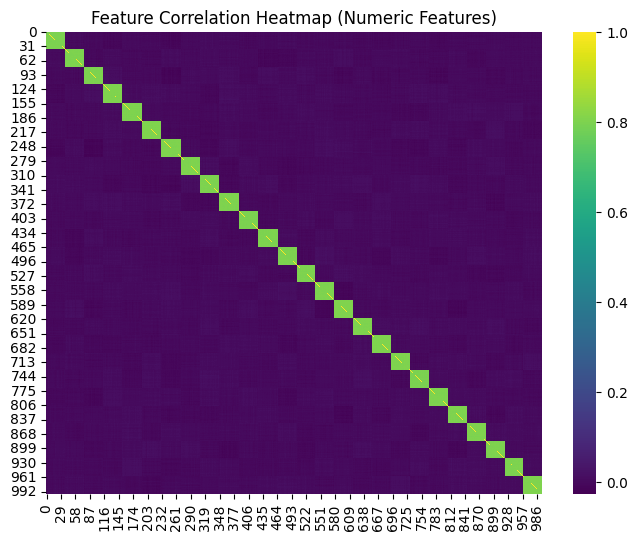


Splitting into train/test sets (80%/20%)...
Training set: (24000, 1000), Testing set: (6000, 1000)

Setting up preprocessing for categorical features...

Initializing Keras-based IGTDCNNClassifier...
Initializing PyTorch-based IGTDCNNClassifier...

Building pipelines...

Fitting Keras-based pipeline...
[fit - initial] X.shape=(24000, 1006)
[fit - initial] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]

[_select_features - input] X.shape=(24000, 1006)
[_select_features - input] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]

Selected 1006 features using variance with threshold=0.05.
[_select_features - output] X.shape=(24000, 1006)
[_select_features - output] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]

[fit] final selected_features_ = ['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]
[_buil

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


Training Epochs:   2%|▏         | 1/50 [00:03<02:43,  3.34s/it]

Train Loss: 1.2109 | Val Loss: 1.0718
Validation loss improved; model saved at best_model_classifier.pth

Epoch 2/50


Training Epochs:   4%|▍         | 2/50 [00:05<02:00,  2.51s/it]

Train Loss: 1.1359 | Val Loss: 1.0752
No improvement (1 epoch).

Epoch 3/50


Training Epochs:   6%|▌         | 3/50 [00:07<01:46,  2.26s/it]

Train Loss: 1.1095 | Val Loss: 0.9848
Validation loss improved; model saved at best_model_classifier.pth

Epoch 4/50


Training Epochs:   8%|▊         | 4/50 [00:09<01:38,  2.13s/it]

Train Loss: 1.0828 | Val Loss: 0.9775
Validation loss improved; model saved at best_model_classifier.pth

Epoch 5/50


Training Epochs:  10%|█         | 5/50 [00:11<01:32,  2.06s/it]

Train Loss: 1.0827 | Val Loss: 0.9976
No improvement (1 epoch).

Epoch 6/50


Training Epochs:  12%|█▏        | 6/50 [00:13<01:28,  2.02s/it]

Train Loss: 1.0748 | Val Loss: 0.9834
No improvement (2 epochs).

Epoch 7/50


Training Epochs:  14%|█▍        | 7/50 [00:14<01:25,  2.00s/it]

Train Loss: 1.0684 | Val Loss: 1.0082
No improvement (3 epochs).

Epoch 8/50


Training Epochs:  16%|█▌        | 8/50 [00:16<01:22,  1.98s/it]

Train Loss: 1.0655 | Val Loss: 1.0151
No improvement (4 epochs).

Epoch 9/50


Training Epochs:  18%|█▊        | 9/50 [00:18<01:20,  1.97s/it]

Train Loss: 1.0685 | Val Loss: 1.0044
No improvement (5 epochs).

Epoch 10/50


Training Epochs:  20%|██        | 10/50 [00:20<01:18,  1.96s/it]

Train Loss: 1.0525 | Val Loss: 0.9674
Validation loss improved; model saved at best_model_classifier.pth

Epoch 11/50


Training Epochs:  22%|██▏       | 11/50 [00:22<01:15,  1.93s/it]

Train Loss: 1.0411 | Val Loss: 1.1349
No improvement (1 epoch).

Epoch 12/50


Training Epochs:  24%|██▍       | 12/50 [00:24<01:13,  1.93s/it]

Train Loss: 1.0371 | Val Loss: 0.9972
No improvement (2 epochs).

Epoch 13/50


Training Epochs:  26%|██▌       | 13/50 [00:26<01:11,  1.92s/it]

Train Loss: 1.0265 | Val Loss: 0.9711
No improvement (3 epochs).

Epoch 14/50


Training Epochs:  28%|██▊       | 14/50 [00:28<01:08,  1.91s/it]

Train Loss: 1.0280 | Val Loss: 0.9966
No improvement (4 epochs).

Epoch 15/50


Training Epochs:  30%|███       | 15/50 [00:30<01:06,  1.90s/it]

Train Loss: 1.0156 | Val Loss: 0.9745
No improvement (5 epochs).

Epoch 16/50


Training Epochs:  32%|███▏      | 16/50 [00:32<01:04,  1.89s/it]

Train Loss: 1.0002 | Val Loss: 1.0039
No improvement (6 epochs).

Epoch 17/50


Training Epochs:  34%|███▍      | 17/50 [00:34<01:02,  1.88s/it]

Train Loss: 1.0072 | Val Loss: 1.0198
No improvement (7 epochs).

Epoch 18/50


Training Epochs:  36%|███▌      | 18/50 [00:35<01:00,  1.88s/it]

Train Loss: 0.9943 | Val Loss: 1.0014
No improvement (8 epochs).

Epoch 19/50


Training Epochs:  38%|███▊      | 19/50 [00:37<00:58,  1.88s/it]

Train Loss: 0.9868 | Val Loss: 0.9976
No improvement (9 epochs).

Epoch 20/50


Training Epochs:  38%|███▊      | 19/50 [00:39<01:04,  2.09s/it]

Train Loss: 0.9716 | Val Loss: 1.0119
No improvement (10 epochs).
Early stopping triggered.
PyTorch pipeline training time: 5776.77s.

Making predictions...
[transform - initial] X.shape=(6000, 1006)
[transform - initial] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]



[transform - initial] X.shape=(6000, 1006)
[transform - initial] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]

Keras IGTDCNN => Accuracy: 0.5655
PyTorch IGTDCNN => Accuracy: 0.5618

Fitting RandomForestClassifier (n_estimators=300) as a benchmark...
RandomForest => Accuracy: 0.4573, Training time: 309.55s

Comparison of results:


,Model,Accuracy,TrainTime(s)
0,Keras IGTDCNN,0.565500,5821.695832
1,PyTorch IGTDCNN,0.561833,5776.765997
2,RandomForest,0.457333,309.546085



Visualizing confusion matrices...


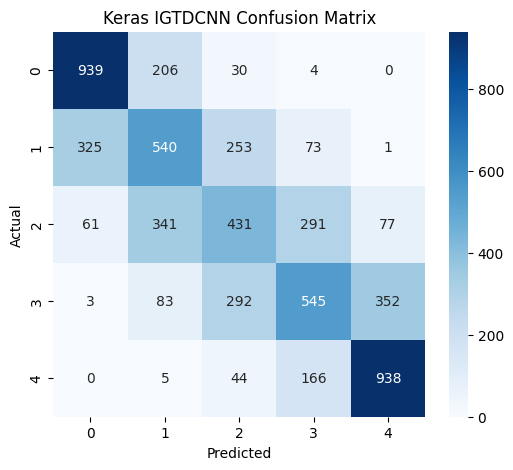

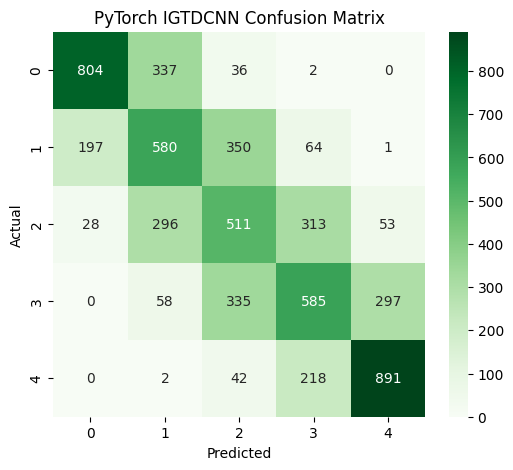

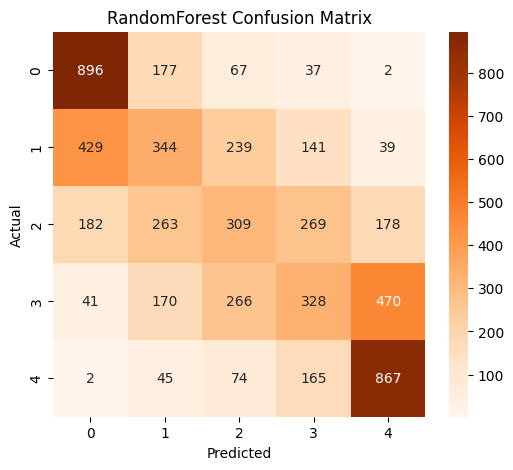


Visualizing IGTDTransformer images for 3 training samples.
Preprocessed Feature Names: ['A_2' 'A_3' 'A_4' ... 'C_1_0' 'C_1_1' 'C_1_2']
Highlighting features: ['A_2', 'A_7', 'A_16', 'B_4', 'B_5']
All highlight features are present in preprocessed data.

Keras pipeline images:
[transform - initial] X.shape=(3, 1006)
[transform - initial] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]



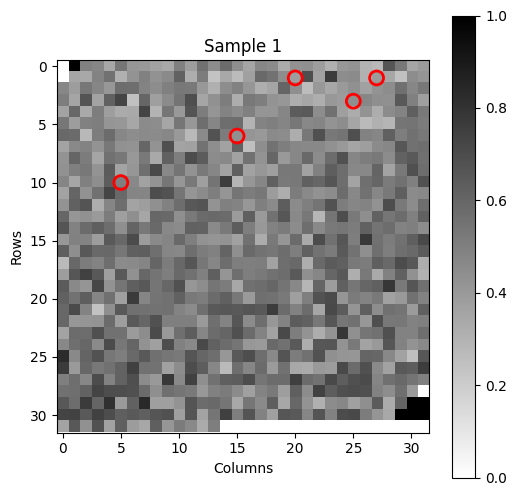

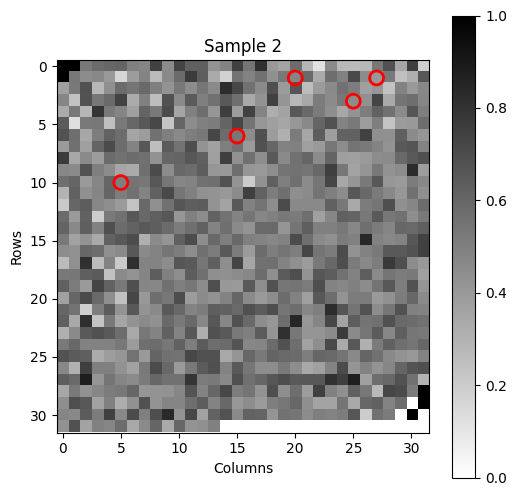

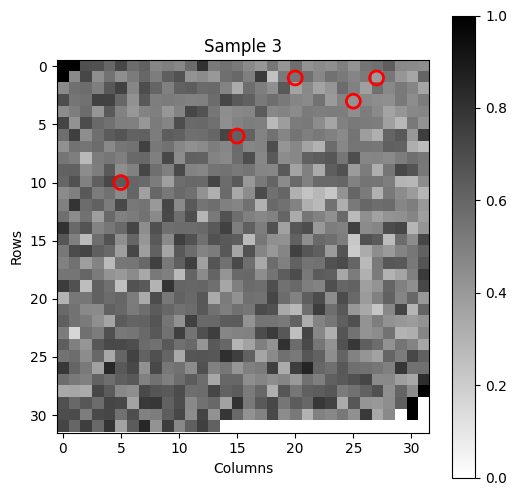


PyTorch pipeline images:
[transform - initial] X.shape=(3, 1006)
[transform - initial] X.columns=['A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', ('...', '...')]



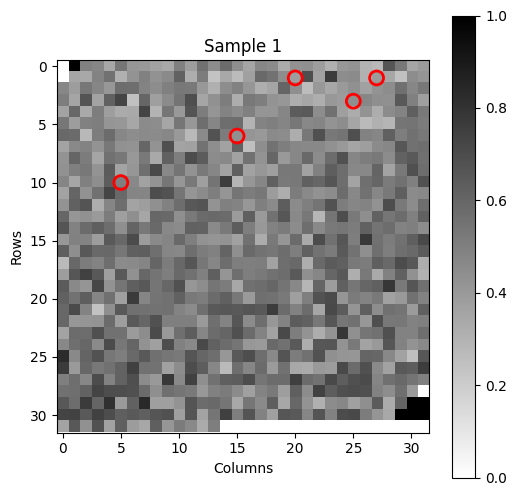

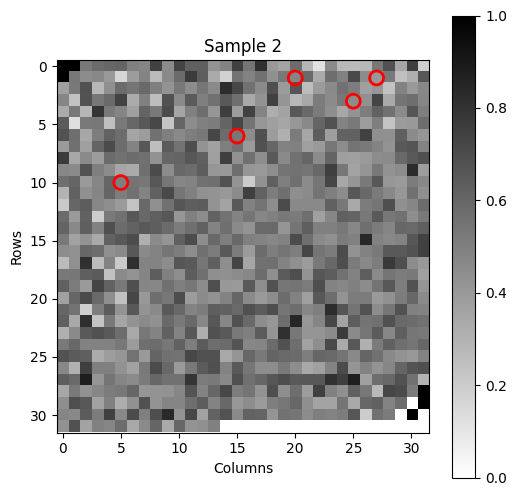

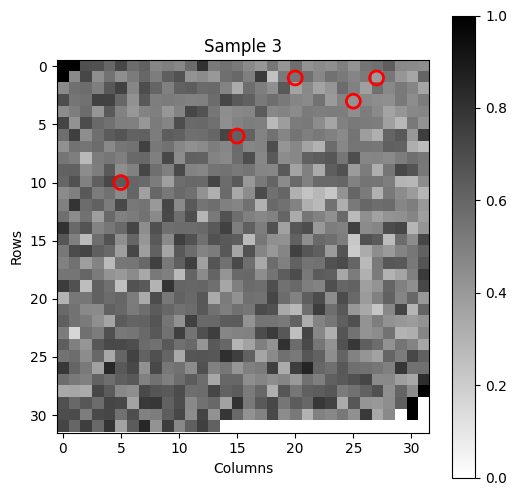

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


def main():
    """
    Demonstration workflow that generates a synthetic classification dataset with:
      - 30,000 samples
      - 1,000 features distributed across 26 correlated blocks (A–Z)
      - A classification target derived from a linear combination of 100 randomly selected features, binned into classes

    We then compare performance between:
      - Keras-based IGTDCNNClassifier
      - PyTorch-based IGTDCNNClassifier
      - RandomForestClassifier benchmark

    We also visualize the correlation matrix and show IGTD-transformed images for
    a few training samples, highlighting a subset of features used in the target.
    """

    print("1) Generating synthetic data with 30k samples and 1k correlated features...")

    # ---------- Step 1: Data Generation ----------
    def generate_block_cov(size, rho=0.8):
        """
        Create a 'size x size' covariance matrix with diagonal=1 and off-diagonal=rho.
        """
        cov_block = np.full((size, size), rho)
        np.fill_diagonal(cov_block, 1.0)
        return cov_block

    # 26 letters => 26 blocks
    letters = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # 'A'..'Z'
    # Distribute 1,000 features across these 26 blocks
    block_sizes = [39] * 12 + [38] * 14
    assert sum(block_sizes) == 1000, "Block sizes must sum to 1000"

    n_samples = 30000
    rng = np.random.default_rng(42)  # reproducible random generator

    # Build block-diagonal covariance
    blocks = [generate_block_cov(sz, rho=0.8) for sz in block_sizes]
    cov_full = block_diag(*blocks)
    mean_vec = np.zeros(sum(block_sizes))

    # Sample from multivariate normal
    X_raw = rng.multivariate_normal(mean_vec, cov_full, size=n_samples)

    # Name the features using letters, e.g., 'A_1'..'A_39', 'B_1'..'B_39', ...
    feature_names = []
    for i, letter in enumerate(letters):
        sz = block_sizes[i]
        for j in range(1, sz + 1):
            feature_names.append(f"{letter}_{j}")

    # ---------- Step 2: Define the Target (classification) ----------
    # Randomly pick 100 distinct feature indices
    target_indices = rng.choice(1000, size=100, replace=False)

    # Assign random coefficients to each chosen feature
    target_coefs = rng.uniform(1.0, 4.0, size=100)

    # Compute linear combination and add noise
    linear_sum = np.dot(X_raw[:, target_indices], target_coefs)
    noise = rng.normal(0, 20.0, size=n_samples)
    linear_sum += noise

    # Convert linear_sum into discrete classes (e.g., 5 classes)
    classes = pd.qcut(linear_sum, q=5, labels=False).astype(np.int64)  # 0 to 4

    # Create a DataFrame
    df = pd.DataFrame(X_raw, columns=feature_names)

    # Introduce categorical features by binning selected numerical features
    categorical_features = ["A_1", "B_1", "C_1"]
    for cat_feat in categorical_features:
        df[cat_feat] = pd.qcut(df[cat_feat], q=3, labels=False).astype('category')

    print(f"DataFrame shape: {df.shape}")
    print("Head of dataset (including categorical features):")
    display(df.head(8))
    classes = pd.Series(classes, name='target')
    print("Class distribution:", classes.value_counts())

    # ---------- Step 3: Data Exploration ----------
    print(f"\nNumber of features: {df.shape[1]}")
    print("First few feature names:", feature_names[:5], "...")
    print("Last few feature names:", feature_names[-5:])

    print("\nComputing correlation matrix for numeric features...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr().values
    print(f"Correlation matrix computed in {time.time():.2f} s. Shape: {corr_matrix.shape}")

    print("Plotting correlation heatmap...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='viridis')
    plt.title("Feature Correlation Heatmap (Numeric Features)")
    plt.show()

    # ---------- Step 4: Train/Test Split ----------
    print("\nSplitting into train/test sets (80%/20%)...")
    X_train, X_test, y_train, y_test = train_test_split(df, classes, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

    # ---------- Step 5: Preprocessing ----------
    print("\nSetting up preprocessing for categorical features...")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", [col for col in df.columns if col not in categorical_features]),
            ("cat", OneHotEncoder(sparse_output=False), categorical_features)
        ],
        remainder='drop',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    # ---------- Step 6: IGTDTransformer parameters ----------
    transformer_params = {
        'image_size': (32, 32),              # 32x32 = 1024 pixels, enough for 1000+ features
        'feature_selection': 'variance',
        'feature_selection_threshold': 0.05,
        'feature_distance': 'euclidean',
        'pixel_distance': 'euclidean',
        'error_measure': 'squared',
        'max_iterations': 2000,
        'tolerance': 1e-4
    }

    # ---------- Step 7: CNN Classifier Params ----------
    cnn_classifier_params = {
        'n_classes': 5,
        'input_shape': (32, 32, 1),
        'num_conv_layers': 2,
        'num_filters': [32, 64],
        'kernel_sizes': [3, 3],
        'activation': 'relu',
        'use_batch_norm': True,
        'dropout_rate': 0.5,
        'optimizer': 'adamw',
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'epochs': 50,
        'batch_size': 32,
        'validation_split': 0.2,
        'early_stopping_patience': 10
    }

    # ---------- Step 8: Initialize IGTDCNNClassifiers ----------
    print("\nInitializing Keras-based IGTDCNNClassifier...")
    igt_cnn_keras = IGTDCNNClassifier(
        backend='keras',
        transformer_params=transformer_params,
        classifier_params=cnn_classifier_params,
        random_state=42,
        verbose=True
    )

    print("Initializing PyTorch-based IGTDCNNClassifier...")
    igt_cnn_pytorch = IGTDCNNClassifier(
        backend='pytorch',
        transformer_params=transformer_params,
        classifier_params=cnn_classifier_params,
        random_state=42,
        verbose=True
    )

    # ---------- Step 9: Build Pipelines ----------
    print("\nBuilding pipelines...")
    pipeline_keras = Pipeline([
        ('preprocessor', preprocessor),
        ('IGTDCNN_Classifier_Keras', igt_cnn_keras)
    ])

    pipeline_pytorch = Pipeline([
        ('preprocessor', preprocessor),
        ('IGTDCNN_Classifier_PyTorch', igt_cnn_pytorch)
    ])

    # ---------- Step 10: Fit Keras Pipeline ----------
    print("\nFitting Keras-based pipeline...")
    start_keras = time.time()
    pipeline_keras.fit(X_train, y_train)
    keras_time = time.time() - start_keras
    print(f"Keras pipeline training time: {keras_time:.2f}s.\n")

    # ---------- Step 11: Fit PyTorch Pipeline ----------
    print("Fitting PyTorch-based pipeline...")
    start_pytorch = time.time()
    pipeline_pytorch.fit(X_train, y_train)
    pytorch_time = time.time() - start_pytorch
    print(f"PyTorch pipeline training time: {pytorch_time:.2f}s.\n")

    # ---------- Step 12: Predictions ----------
    print("Making predictions...")
    y_pred_keras = pipeline_keras.predict(X_test)
    y_pred_pytorch = pipeline_pytorch.predict(X_test)

    acc_keras = accuracy_score(y_test, y_pred_keras)
    acc_pytorch = accuracy_score(y_test, y_pred_pytorch)

    print(f"Keras IGTDCNN => Accuracy: {acc_keras:.4f}")
    print(f"PyTorch IGTDCNN => Accuracy: {acc_pytorch:.4f}\n")

    # ---------- Step 13: RandomForest Benchmark ----------
    print("Fitting RandomForestClassifier (n_estimators=300) as a benchmark...")
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    start_rf = time.time()
    rf.fit(X_train, y_train)
    rf_time = time.time() - start_rf

    y_pred_rf = rf.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    print(f"RandomForest => Accuracy: {acc_rf:.4f}, Training time: {rf_time:.2f}s\n")

    # ---------- Step 14: Compare Results ----------
    comparison_df = pd.DataFrame({
        'Model': ['Keras IGTDCNN', 'PyTorch IGTDCNN', 'RandomForest'],
        'Accuracy': [acc_keras, acc_pytorch, acc_rf],
        'TrainTime(s)': [keras_time, pytorch_time, rf_time]
    })
    print("Comparison of results:")
    display(comparison_df)

    # ---------- Step 15: Visualize Confusion Matrices ----------
    print("\nVisualizing confusion matrices...")

    # Keras Confusion Matrix
    cm_keras = confusion_matrix(y_test, y_pred_keras)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues')
    plt.title("Keras IGTDCNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # PyTorch Confusion Matrix
    cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Greens')
    plt.title("PyTorch IGTDCNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # RandomForest Confusion Matrix
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
    plt.title("RandomForest Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ---------- Step 16: Visualize IGTD Images ----------
    print("\nVisualizing IGTDTransformer images for 3 training samples.")
    # Define the original categorical features that were transformed
    transformed_features = ["A_1", "B_1", "C_1"]

    # Retrieve preprocessed feature names
    preprocessed_feature_names = pipeline_keras.named_steps['preprocessor'].get_feature_names_out()
    print("Preprocessed Feature Names:", preprocessed_feature_names)

    # Identify all one-hot encoded feature names for the transformed features
    onehot_feature_names = []
    for feat in transformed_features:
        # Find all one-hot encoded features for this categorical feature
        matching_features = [f"{feat}_{i}" for i in range(3)]
        onehot_feature_names.extend(matching_features)

    # Highlight the first 5 features that contributed to the target, excluding transformed features
    highlight_indices = []
    for idx in sorted(target_indices[:100]):
        feature_name = feature_names[idx]
        if feature_name not in transformed_features:
            # Ensure the feature exists in preprocessed data
            if feature_name in preprocessed_feature_names:
                highlight_indices.append(idx)
        if len(highlight_indices) == 5:
            break

    highlight_features = [feature_names[i] for i in highlight_indices]
    print("Highlighting features:", highlight_features)

    # Verify that these features are present in the preprocessed feature names
    missing_features = [feat for feat in highlight_features if feat not in preprocessed_feature_names]
    if missing_features:
        print(f"Warning: The following highlight features are not in preprocessed data and cannot be highlighted: {missing_features}")
    else:
        print("All highlight features are present in preprocessed data.")

    # Keras pipeline images
    preprocessed_sample_keras = pipeline_keras.named_steps['preprocessor'].transform(X_train.iloc[:3, :])
    igtd_keras = pipeline_keras.named_steps['IGTDCNN_Classifier_Keras'].transformer_
    print("\nKeras pipeline images:")
    igtd_keras.plot_transformed_images(
        samples=preprocessed_sample_keras,
        num_samples=3,
        highlight_features=highlight_features,
        annotate=False
    )

    # PyTorch pipeline images
    preprocessed_sample_pytorch = pipeline_pytorch.named_steps['preprocessor'].transform(X_train.iloc[:3, :])
    igtd_pytorch = pipeline_pytorch.named_steps['IGTDCNN_Classifier_PyTorch'].transformer_
    print("\nPyTorch pipeline images:")
    igtd_pytorch.plot_transformed_images(
        samples=preprocessed_sample_pytorch,
        num_samples=3,
        highlight_features=highlight_features,
        annotate=False
    )

if __name__ == "__main__":
    main()